In [1]:
config_file = "/users/kcochran/projects/new_procap_models/modisco_out/procap/"
config_file += "K562/strand_merged_umap/2022-10-05_03-39-32_profile_in/config.json"

In [2]:
# need to specify for every expt

patterns_to_keep = [0,1,2,3,4,5,7,8,9,10,13,14,15]

# This is specific to K562

motif_keys_to_labels = ["BRE/SP", "CA-Inr", "GABPA", "NFY", "NRF1", "ATF1",
                        "YY1", "TA-Inr", "TATA", "THAP11",
                        "AP1",  "CTCF", "ZBTB33"]

In [3]:
import os
import numpy as np
import sys
sys.path.append("../2_train_models")
sys.path.append("../5_modisco")
from utils import load_json
from data_loading import extract_peaks
from modiscolite_utils import load_scores, load_observed_profiles
from file_configs import ValFilesConfig, TrainFilesConfig
import matplotlib.pyplot as plt
from collections import defaultdict

%matplotlib inline

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
Matplotlib is building the font cache; this may take a moment.


In [4]:
config = load_json(config_file)

proj_dir = config["proj_dir"]

cell_type = config["cell_type"]
model_type = config["model_type"]
timestamp = config["timestamp"]
data_type = config["data_type"]

genome_path = config["genome_path"]
chrom_sizes = config["chrom_sizes"]

in_window = config["in_window"]
out_window = config["out_window"]

slice_len = config["slice"]

peak_path = config["train_val_peak_path"]

modisco_results_path = config["results_save_path"]

scores_path = config["scores_path"]

# need filepaths from these
train_config = TrainFilesConfig(cell_type, model_type, timestamp, data_type)
val_config = ValFilesConfig(cell_type, model_type, timestamp, data_type)

val_peak_path = val_config.val_peak_path

Timestamp: 2022-10-05_03-39-32
Timestamp: 2022-10-05_03-39-32


In [5]:
from motif_hits_utils import load_coords

coords = load_coords(peak_path, in_window=in_window)
val_coords = load_coords(val_peak_path, in_window=in_window)

In [6]:
from load_annotations_utils import find_peak_overlap_labels, get_ccre_bed

ccre_bed = get_ccre_bed(cell_type)

ccre_annots = find_peak_overlap_labels(coords, ccre_bed, in_window, out_window)
val_ccre_annots = find_peak_overlap_labels(val_coords, ccre_bed, in_window, out_window)

In [7]:
ccre_annots["PLS_no_pELS"] = ccre_annots["PLS"] * (~ ccre_annots["pELS"])
ccre_annots["PLS_with_pELS"] = ccre_annots["PLS"] * ccre_annots["pELS"]

val_ccre_annots["PLS_no_pELS"] = val_ccre_annots["PLS"] * (~ val_ccre_annots["pELS"])
val_ccre_annots["PLS_with_pELS"] = val_ccre_annots["PLS"] * val_ccre_annots["pELS"]

In [8]:
onehot_seqs, true_profs = extract_peaks(genome_path,
                                        chrom_sizes,
                                        train_config.plus_bw_path,
                                        train_config.minus_bw_path,
                                        peak_path,
                                        in_window=in_window,
                                        out_window=out_window,
                                        max_jitter=0,
                                        verbose=True)

scores = load_scores(scores_path,
                     slice_len=slice_len,
                     in_window=in_window)

true_counts = true_profs.sum(axis=(1,2))  # strand-merged

pred_profs = np.exp(np.load(val_config.pred_profiles_train_val_path))
pred_counts = np.exp(np.load(val_config.pred_logcounts_train_val_path)).squeeze()

Loading genome sequence from /mnt/lab_data2/kcochran/new_procap_models/genomes/hg38.withrDNA.fasta


Reading FASTA: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [00:11<00:00,  2.17it/s]
Loading Peaks: 17184it [05:58,  1.68it/s] IOStream.flush timed out
Loading Peaks: 27000it [12:31, 35.92it/s] 


== In Extract Peaks ==
Peak filepath: /mnt/lab_data2/kcochran/new_procap_models/deepshap_out/procap/K562/strand_merged_umap/2022-10-05_03-39-32_in/peaks_uni_and_bi_train_and_val.bed.gz
Sequence length (with jitter): 2114
Profile length (with jitter): 1000
Max jitter applied: 0
Num. Examples: 27000
Mask loaded? False


In [9]:
val_profs = load_observed_profiles(val_config.plus_bw_path,
                                   val_config.minus_bw_path,
                                   val_config.val_peak_path,
                                   slice_len=slice_len,
                                   out_window=out_window)

val_counts = val_profs.sum(axis=(1,2))  # strand-merged

val_pred_counts = np.exp(np.load(val_config.pred_logcounts_val_path)).squeeze()

== In Extract Profiles ==
Peak filepath: /mnt/lab_data2/kcochran/new_procap_models/models/procap/K562/strand_merged_umap/2022-10-05_03-39-32_in/peaks_uni_and_bi_val.bed.gz
Profile length: 1000
Num. Examples: 3834


PLS_with_pELS
Pred. vs. Obs. MSE: 0.81492615
Pred vs. Obs Pearson r: 0.44053494703761775

PLS_no_pELS
Pred. vs. Obs. MSE: 1.2170386
Pred vs. Obs Pearson r: 0.42977070522896904

dELS
Pred. vs. Obs. MSE: 1.8392482
Pred vs. Obs Pearson r: 0.4650902067586361



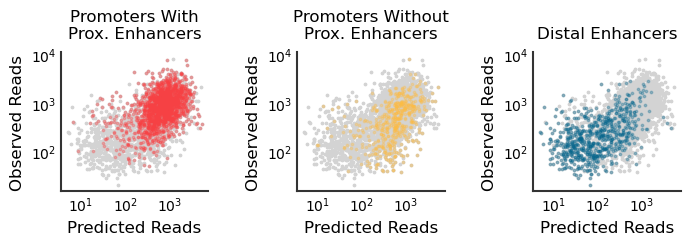

In [47]:
def plot_true_pred_counts_by_annot(true_counts, pred_counts, overlap_annots_bools):
    
    annots_to_labels = {"PLS" : "Promoters",
                        "pELS" : "Proximal Enhancers",
                        "dELS" : "Distal Enhancers",
                        "PLS_with_pELS" : "Promoters With\nProx. Enhancers",
                        "PLS_no_pELS" : "Promoters Without\nProx. Enhancers" }
    
    annots_to_colors = {"PLS" : "#f94144",
                        "pELS" : "#ffbc42",
                        "dELS" : "#05668d",
                        "PLS_with_pELS" : "#f94144",
                        "PLS_no_pELS" : "#ffbc42"}
    
    fig, axes = plt.subplots(1,3,figsize=(8,1.8))
    
    annots_to_plot = ["PLS_with_pELS", "PLS_no_pELS", "dELS"] #["PLS", "pELS", "dELS"]
    
    all_x = []
    all_y = []
    for annot_name in annots_to_plot:
        all_x.extend(pred_counts[overlap_annots_bools[annot_name]])
        all_y.extend(true_counts[overlap_annots_bools[annot_name]])
    
    for ax, sup_annot_name in zip(axes, annots_to_plot):
        ax.scatter(all_x, all_y, alpha = 1, s = 3,
                    label = "Other", color = "lightgray")
        
        # have to plot last
        true_counts_subset = true_counts[overlap_annots_bools[sup_annot_name]]
        pred_counts_subset = pred_counts[overlap_annots_bools[sup_annot_name]]
        
        mse = np.mean((np.log1p(pred_counts_subset) - np.log1p(true_counts_subset)) ** 2)
        print(sup_annot_name)
        print("Pred. vs. Obs. MSE:", mse)
        print("Pred vs. Obs Pearson r:", np.corrcoef(np.log1p(pred_counts_subset), np.log1p(true_counts_subset))[0,1])
        print("")
        
        ax.scatter(pred_counts_subset, true_counts_subset, alpha = 0.3, s = 3,
                    label = annots_to_labels[sup_annot_name],
                    color = annots_to_colors[sup_annot_name])

        ax.semilogy()
        ax.semilogx()

        ax.set_xlabel("Predicted Reads", fontsize = 12)
        ax.set_ylabel("Observed Reads", fontsize = 12)

        ax.spines["left"].set_linewidth(1.5)
        ax.spines["bottom"].set_linewidth(1.5)
        ax.spines["left"].set_color("#333333")
        ax.spines["bottom"].set_color("#333333")
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.xaxis.set_ticks_position('none') 
        ax.yaxis.set_ticks_position('none')
        ax.tick_params(axis='both', labelsize=10, length=0)
        
        ax.set_title(annots_to_labels[sup_annot_name], fontsize=12, pad=10)

    plt.subplots_adjust(wspace=0.6)
    plt.show()

    
plot_true_pred_counts_by_annot(val_counts, val_pred_counts, val_ccre_annots)

In [46]:
mse = np.mean((np.log1p(val_pred_counts) - np.log1p(val_counts)) ** 2)
mse

1.2752919

In [49]:
mse = np.mean((np.log1p(val_pred_counts[val_ccre_annots["PLS"]]) - np.log1p(val_counts[val_ccre_annots["PLS"]])) ** 2)
mse

0.9013351

In [10]:
from BPNet_strand_merged_umap import Model
import torch

# re-define the model's forward func so that it returns output of intermediate layer

class BPNet_Embeddings_Loader(Model):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def forward(self, X):
        start, end = self.trimming, X.shape[2] - self.trimming

        X = self.relus[0](self.iconv(X))

        for i in range(self.n_layers):
            X_conv = self.relus[i+1](self.rconvs[i](X))
            X = torch.add(X, X_conv)
            
        X = X[:, :, start - self.deconv_kernel_size//2 : end + self.deconv_kernel_size//2]

        # return result of global avg pooling
        # (beginning of counts head, before linear layer)
        X = torch.mean(X, axis=2)
        return X

    
# the arch-related args here have to match what was input when the model was trained
params = load_json(train_config.params_path)

embedder = BPNet_Embeddings_Loader("_",
                                   n_filters=params["n_filters"],
                                   n_layers=params["n_layers"],
                                   trimming=params["trimming"],
                                   alpha=params["counts_weight"])

loaded_model_state = torch.load(train_config.model_save_path).state_dict()
embedder.load_state_dict(loaded_model_state)

<All keys matched successfully>

In [11]:
embedder

BPNet_Embeddings_Loader(
  (iconv): Conv1d(4, 512, kernel_size=(21,), stride=(1,), padding=(10,))
  (rconvs): ModuleList(
    (0): Conv1d(512, 512, kernel_size=(3,), stride=(1,), padding=(2,), dilation=(2,))
    (1): Conv1d(512, 512, kernel_size=(3,), stride=(1,), padding=(4,), dilation=(4,))
    (2): Conv1d(512, 512, kernel_size=(3,), stride=(1,), padding=(8,), dilation=(8,))
    (3): Conv1d(512, 512, kernel_size=(3,), stride=(1,), padding=(16,), dilation=(16,))
    (4): Conv1d(512, 512, kernel_size=(3,), stride=(1,), padding=(32,), dilation=(32,))
    (5): Conv1d(512, 512, kernel_size=(3,), stride=(1,), padding=(64,), dilation=(64,))
    (6): Conv1d(512, 512, kernel_size=(3,), stride=(1,), padding=(128,), dilation=(128,))
    (7): Conv1d(512, 512, kernel_size=(3,), stride=(1,), padding=(256,), dilation=(256,))
  )
  (fconv): Conv1d(512, 2, kernel_size=(75,), stride=(1,))
  (relus): ModuleList(
    (0): ReLU()
    (1): ReLU()
    (2): ReLU()
    (3): ReLU()
    (4): ReLU()
    (5): Re

In [12]:
#os.environ["CUDA_VISIBLE_DEVICES"] = "MIG-40f43250-998e-586a-ac37-d6520e92590f"
os.environ["CUDA_VISIBLE_DEVICES"] = "6"

embedder.eval()
embedder = embedder.cuda()

In [13]:
def get_embeddings(embedder, seqs, batch_size=128):
    if not seqs.shape[-2] == 4:
        seqs = np.swapaxes(seqs, -2, -1)
    seqs = torch.tensor(seqs, dtype=torch.float)
    embedder = embedder.cuda()
    with torch.no_grad():
        starts = np.arange(0, seqs.shape[0], batch_size)
        ends = starts + batch_size

        embeds = []
        for i, (start, end) in enumerate(zip(starts, ends)):
            if i % 10 == 0:
                print("Batch " + str(i) + " of " + str(len(starts)))
            
            seqs_batch = seqs[start:end]
            embeds_batch = embedder(seqs_batch.cuda()).cpu().detach().numpy()
            embeds.append(embeds_batch)

    embedder = embedder.cpu()
    return np.concatenate(embeds)

peak_embeds = get_embeddings(embedder, onehot_seqs)

Batch 0 of 211
Batch 10 of 211
Batch 20 of 211
Batch 30 of 211
Batch 40 of 211
Batch 50 of 211
Batch 60 of 211
Batch 70 of 211
Batch 80 of 211
Batch 90 of 211
Batch 100 of 211
Batch 110 of 211
Batch 120 of 211
Batch 130 of 211
Batch 140 of 211
Batch 150 of 211
Batch 160 of 211
Batch 170 of 211
Batch 180 of 211
Batch 190 of 211
Batch 200 of 211
Batch 210 of 211


In [14]:
peak_embeds

array([[0.00793863, 0.03003851, 0.02376998, ..., 0.01035993, 0.14091788,
        0.06037785],
       [0.01115191, 0.03345607, 0.02252001, ..., 0.0135703 , 0.14266135,
        0.05017686],
       [0.01419436, 0.02334539, 0.04809463, ..., 0.03943525, 0.12689619,
        0.05573117],
       ...,
       [0.01383179, 0.01757896, 0.05491781, ..., 0.03251595, 0.08679914,
        0.04273102],
       [0.02027073, 0.02737194, 0.03567499, ..., 0.02237213, 0.04949317,
        0.03909505],
       [0.01546966, 0.03339285, 0.02500893, ..., 0.0104342 , 0.07282893,
        0.0373729 ]], dtype=float32)

In [15]:
promoter_embeds = peak_embeds[ccre_annots["PLS"]]
promoters_with_pELS_embeds = peak_embeds[ccre_annots["PLS"] * ccre_annots["pELS"]]
promoters_no_pELS_embeds = peak_embeds[ccre_annots["PLS"] * (~ ccre_annots["pELS"])]
d_enhancer_embeds = peak_embeds[ccre_annots["dELS"]]

print(len(promoter_embeds), len(promoters_with_pELS_embeds), len(promoters_no_pELS_embeds), len(d_enhancer_embeds))

14829 11992 2837 5097


In [16]:
from sklearn.decomposition import PCA

pca = PCA(n_components=10)
pcs = pca.fit(peak_embeds)
promoter_pcs = pca.transform(promoter_embeds)
d_enhancer_pcs = pca.transform(d_enhancer_embeds)
promoters_with_pELS_pcs = pca.transform(promoters_with_pELS_embeds)
promoters_no_pELS_pcs = pca.transform(promoters_no_pELS_embeds)

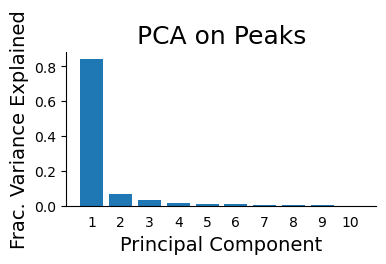

In [17]:
plt.figure(figsize=(4,2))
plt.bar(range(1, 10+1), pca.explained_variance_ratio_)
plt.xlabel("Principal Component", fontsize = 14)
plt.ylabel("Frac. Variance Explained", fontsize = 14)
plt.title("PCA on Peaks", fontsize = 18)

plt.xticks(range(1, 10+1))
for side in ["right", "top"]:
    plt.gca().spines[side].set_visible(False)
plt.gca().xaxis.set_ticks_position('none') 

plt.show()

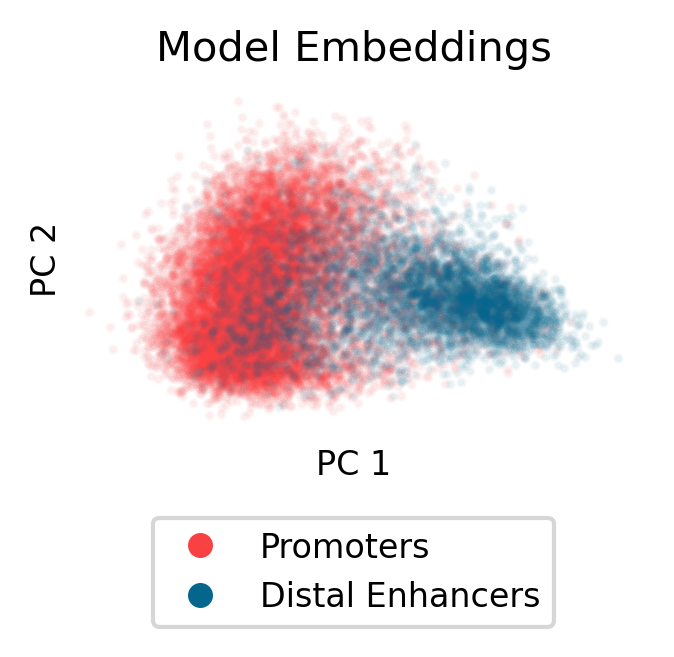

In [37]:
from matplotlib.lines import Line2D

def plot_embeds_pca(promoter_pcs, d_enhancer_pcs):
    plt.figure(figsize=(2.5,1.5), dpi=300)

    plt.scatter(promoter_pcs[..., 0], promoter_pcs[..., 1],
                alpha = 0.05, s = 2, c="#f94144")
    plt.scatter(d_enhancer_pcs[..., 0], d_enhancer_pcs[..., 1],
                alpha = 0.05, s = 2, c="#05668d")

    plt.xlabel("PC 1", fontsize = 8)
    plt.ylabel("PC 2", fontsize = 8, labelpad=0)
    plt.title("Model Embeddings", fontsize = 10)

    for side in ["right", "top", "bottom", "left"]:
        plt.gca().spines[side].set_visible(False)
    plt.xticks([])
    plt.yticks([])
    plt.tick_params("both", length=0)


    legend_elements = [Line2D([0], [0], marker='o', color='w', label='Promoters',
                              markerfacecolor="#f94144", markersize=7),
                       Line2D([0], [0], marker='o', color='w', label='Distal Enhancers',
                              markerfacecolor="#05668d", markersize=7)]

    plt.legend(handles=legend_elements, fontsize = 8,
               loc='upper center', bbox_to_anchor = (0.5, -0.2))

    plt.show()
    
plot_embeds_pca(promoter_pcs, d_enhancer_pcs)

In [12]:
def get_orientation_indexes(profiles):
    return np.max(profiles.sum(axis=-1), axis=-1) / np.sum(profiles, axis=(-1,-2))

ois = get_orientation_indexes(true_profs)

In [13]:
def inverse_hist(profile):
    assert len(profile.shape) == 1 or (len(profile.shape) == 2 and profile.shape[0] == 2), profile.shape

    profile = profile.sum(axis=0).astype(int)
    return np.repeat(range(len(profile)), profile)

def get_variances(profiles):
    return np.array([np.var(inverse_hist(profile)) for profile in profiles])

variances = get_variances(true_profs)

In [54]:
promoter_ois = ois[ccre_annots["PLS"]]
p_enhancer_ois = ois[ccre_annots["pELS"]]
d_enhancer_ois = ois[ccre_annots["dELS"]]

In [81]:
promoter_vars = variances[ccre_annots["PLS"]]
p_enhancer_vars = variances[ccre_annots["pELS"]]
d_enhancer_vars = variances[ccre_annots["dELS"]]

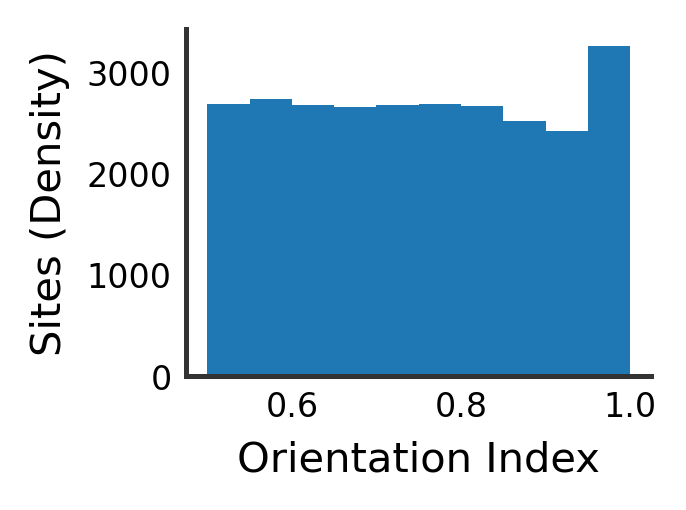

In [53]:
plt.figure(figsize=(2,1.5), dpi=300)

plt.hist(ois)

plt.xlabel("Orientation Index", fontsize=10)
plt.ylabel("Sites (Density)", fontsize=10)

ax = plt.gca()
ax.spines["left"].set_linewidth(1.2)
ax.spines["bottom"].set_linewidth(1.2)
ax.spines["left"].set_color("#333333")
ax.spines["bottom"].set_color("#333333")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.tick_params(length=0, labelsize=8)

plt.show()

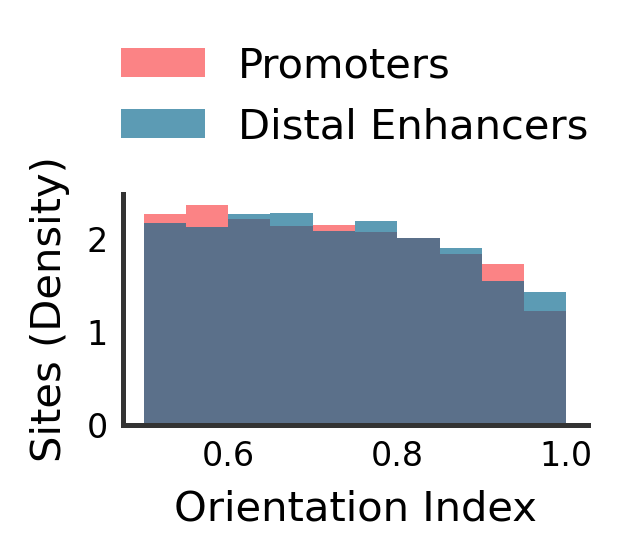

In [78]:
plt.figure(figsize=(2,1), dpi=300)

plt.hist(promoter_ois, density=True, alpha=0.65, label="Promoters", color="#f94144")
plt.hist(d_enhancer_ois, density=True, alpha=0.65, label="Distal Enhancers", color="#05668d")

plt.xlabel("Orientation Index", fontsize=10)
plt.ylabel("Sites (Density)", fontsize=10)
plt.legend(bbox_to_anchor=(0.5, 1.8), loc="upper center", frameon=False, fontsize=10)

ax = plt.gca()
ax.spines["left"].set_linewidth(1.2)
ax.spines["bottom"].set_linewidth(1.2)
ax.spines["left"].set_color("#333333")
ax.spines["bottom"].set_color("#333333")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.tick_params(length=0, labelsize=8)

plt.show()

In [162]:
#from common_functions import get_norm_shannon_entropies

norm_shannon_entropies = get_norm_shannon_entropies(true_profs, true_counts)
promoter_nses = norm_shannon_entropies[ccre_annots["PLS"]]
enhancer_nses = norm_shannon_entropies[ccre_annots["dELS"]]

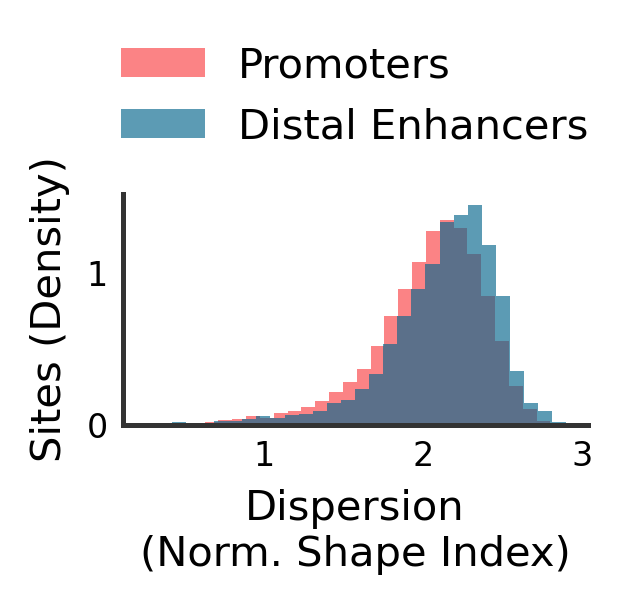

In [164]:
plt.figure(figsize=(2,1), dpi=300)

plt.hist(promoter_nses, density=True, alpha=0.65, label="Promoters", color="#f94144", bins=30)
plt.hist(enhancer_nses, density=True, alpha=0.65, label="Distal Enhancers", color="#05668d", bins=30)

plt.xlabel("Dispersion\n(Norm. Shape Index)", fontsize=10)
plt.ylabel("Sites (Density)", fontsize=10)
plt.legend(bbox_to_anchor=(0.5, 1.8), loc="upper center", frameon=False, fontsize=10)

ax = plt.gca()
ax.spines["left"].set_linewidth(1.2)
ax.spines["bottom"].set_linewidth(1.2)
ax.spines["left"].set_color("#333333")
ax.spines["bottom"].set_color("#333333")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.tick_params(length=0, labelsize=8)

plt.show()

In [ ]:
plt.figure(figsize=(2,1), dpi=300)

plt.hist(np.sqrt(promoter_vars), density=True, alpha=0.65, label="Promoters", color="#f94144", bins=30)
plt.hist(np.sqrt(d_enhancer_vars), density=True, alpha=0.65, label="Distal Enhancers", color="#05668d", bins=30)

plt.xlabel("Dispersion (Std. Dev.)", fontsize=10)
plt.ylabel("Sites (Density)", fontsize=10)
plt.legend(bbox_to_anchor=(0.5, 1.8), loc="upper center", frameon=False, fontsize=10)

ax = plt.gca()
ax.spines["left"].set_linewidth(1.2)
ax.spines["bottom"].set_linewidth(1.2)
ax.spines["left"].set_color("#333333")
ax.spines["bottom"].set_color("#333333")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.tick_params(length=0, labelsize=8)

plt.show()

In [166]:
from matplotlib import colormaps as cmaps

def plot_embeds_pca_with_ois(promoter_pcs, d_enhancer_pcs, promoter_ois, d_enhancer_ois):
    plt.figure(figsize=(6,3))

    cmap = cmaps["viridis"]
    plt.scatter(promoter_pcs[..., 0], promoter_pcs[..., 1],
                alpha = 0.2, s = 7, c=promoter_ois, cmap=cmap)
    plt.scatter(d_enhancer_pcs[..., 0], d_enhancer_pcs[..., 1],
                alpha = 0.2, s = 7, c=d_enhancer_ois, cmap=cmap)
    

    plt.xlabel("PC 1", fontsize = 16)
    plt.ylabel("PC 2", fontsize = 16)
    plt.title("Peak Embeddings", fontsize = 20)

    for side in ["right", "top", "bottom", "left"]:
        plt.gca().spines[side].set_visible(False)
    plt.xticks([])
    plt.yticks([])
    plt.tick_params("both", length=0)

    plt.colorbar()

    plt.show()
    
plot_embeds_pca_with_ois(promoter_pcs, d_enhancer_pcs, promoter_ois, d_enhancer_ois)

NameError: name 'promoter_pcs' is not defined

In [165]:
from matplotlib import colormaps as cmaps

def plot_embeds_pca_with_ois(peak_pcs, ois):
    plt.figure(figsize=(6,3))

    cmap = cmaps["viridis"]
    plt.scatter(peak_pcs[..., 0], peak_pcs[..., 1],
                alpha = 0.2, s = 7, c=ois, cmap=cmap)
    

    plt.xlabel("PC 1", fontsize = 16)
    plt.ylabel("PC 2", fontsize = 16)
    plt.title("Peak Embeddings", fontsize = 20)

    for side in ["right", "top", "bottom", "left"]:
        plt.gca().spines[side].set_visible(False)
    plt.xticks([])
    plt.yticks([])
    plt.tick_params("both", length=0)

    plt.colorbar()

    plt.show()
    
plot_embeds_pca_with_ois(peak_pcs, ois)

NameError: name 'peak_pcs' is not defined

(27000,)
0.10895031930502988


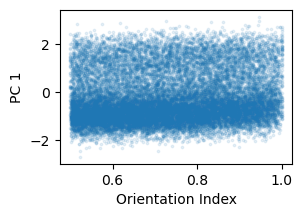

0.0035873442313348078


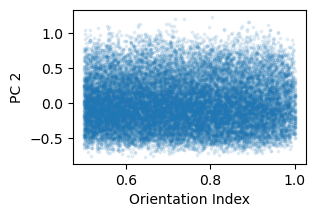

0.034923385415739874


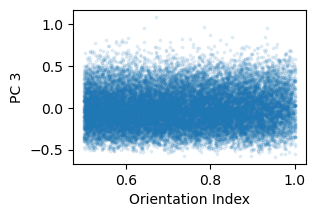

0.05344032679120075


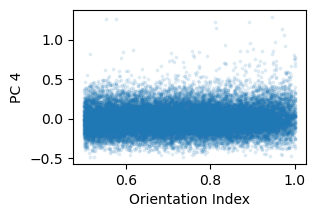

-0.04088851951085606


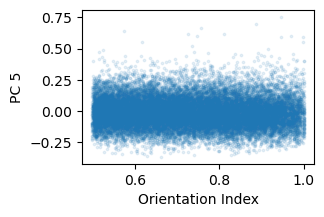

0.07234321615001328


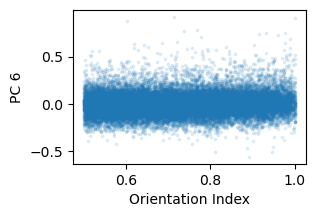

-0.0001659071581057563


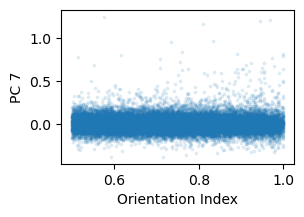

0.043758763500524024


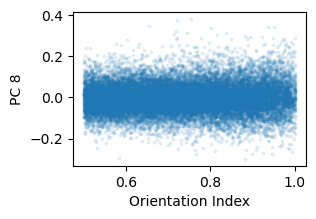

0.07620094669687952


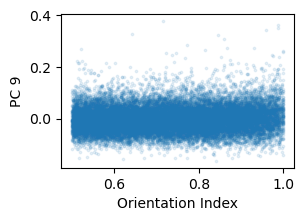

0.06035227976340185


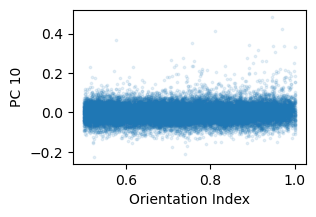

In [68]:
peak_pcs = pca.transform(peak_embeds)

any_ccre_annots = np.clip(ccre_annots["PLS"] + ccre_annots["pELS"] + ccre_annots["dELS"], 0, 1).astype(bool)
print(any_ccre_annots.shape)
any_ccre_peak_pcs = peak_pcs[any_ccre_annots]
any_ccre_ois = ois[any_ccre_annots]

for i in range(peak_pcs.shape[1]):
    plt.figure(figsize=(3,2))
    print(np.corrcoef(any_ccre_ois, any_ccre_peak_pcs[..., i])[0,1])
    plt.scatter(any_ccre_ois, any_ccre_peak_pcs[..., i], s=3, alpha=0.1)
    plt.xlabel("Orientation Index")
    plt.ylabel("PC " + str(i + 1))
    plt.show()

In [38]:
### Load Motifs

from motif_hits_utils import load_motif_hits

motif_hits, motif_hits_peaks, motif_hit_counts = load_motif_hits(cell_type, model_type, timestamp)

Timestamp: 2022-10-05_03-39-32
Timestamp: 2022-10-05_03-39-32


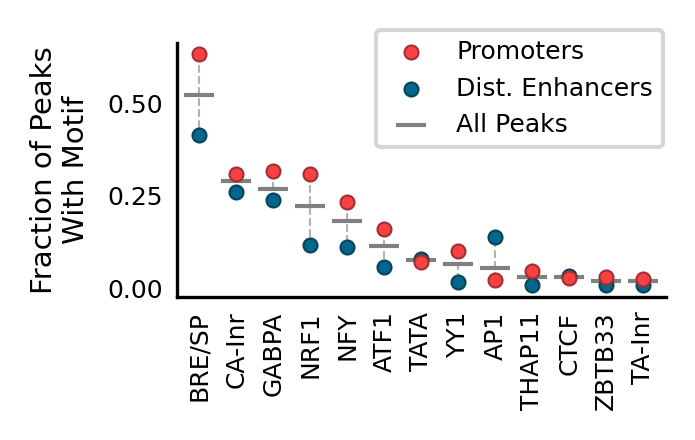

In [145]:
from collections import defaultdict

def plot_motif_enrichment_in_cCREs_condensed(peak_hit_counts, overlap_annots_bools,
                                        annots_to_plot = ["PLS", "dELS"],
                                        motif_keys_to_labels = motif_keys_to_labels):
    
    annots_to_labels = {"PLS" : "Promoters",
                        "pELS" : "Proximal Enhancers",
                        "dELS" : "Dist. Enhancers"}
    
    annots_to_colors = {"All Peaks" : "gray", "PLS" : "#f94144", "dELS" : "#05668d"}
    annots_to_edgecolors = {"All Peaks" : "gray", "PLS" : "#A12F31", "dELS" : "#05435C"}
    annots_to_sizes = {"All Peaks" : 50, "PLS" : 45, "dELS" : 45}
    
    annot_vals = defaultdict(lambda : [])
    
    motif_keys = range(len(motif_keys_to_labels))
    for motif_index in motif_keys:
        total_peaks_with_motif = np.sum(peak_hit_counts[:, motif_index] > 0)

        for key in annots_to_plot:
            overlap_peaks = np.sum(overlap_annots_bools[key])
            overlap_peaks_with_motif = np.sum(peak_hit_counts[overlap_annots_bools[key], motif_index] > 0)

            annot_vals[key].append(overlap_peaks_with_motif / overlap_peaks)
            
        annot_vals["All Peaks"].append(total_peaks_with_motif / peak_hit_counts.shape[0])

    plot_order = np.argsort(annot_vals["All Peaks"])[::-1]
        
    plt.figure(figsize=(2.1, 1.1), dpi=300)
    
    add_to_legend = True
    for y, plot_i in enumerate(plot_order):
        plt.plot([y] * 2,
                 [annot_vals["PLS"][plot_i], annot_vals["dELS"][plot_i]],
                 color="gray", alpha = 0.6, linewidth=0.5, linestyle="dashed")
        
        for i, (key, vals) in enumerate(annot_vals.items()):
            if key == "All Peaks":
                plt.scatter(y, vals[plot_i],
                            label=key if add_to_legend else "",
                            color=annots_to_colors[key],
                            linewidth=1,
                            s=annots_to_sizes[key],
                            zorder=10 - i, marker="_")
            else:
                plt.scatter(y, vals[plot_i],
                            label=annots_to_labels[key] if add_to_legend else "",
                            color=annots_to_colors[key],
                            edgecolor=annots_to_edgecolors[key],
                            linewidth=0.5,
                            s=annots_to_sizes[key],
                            zorder=10 - i, marker=".")
            
        add_to_legend = False

    plt.legend(fontsize=6, loc="upper right", bbox_to_anchor=(1.02, 1.1))
    plt.xticks(motif_keys, np.array(motif_keys_to_labels)[plot_order],
               fontsize=6, rotation=90)
    plt.tick_params(left=False, length=0)
    plt.yticks([0.0, 0.25, 0.5], fontsize=6)
    plt.ylabel("Fraction of Peaks\nWith Motif", fontsize=7)
    
    plt.gca().spines[["top", "right"]].set_visible(False)

    plt.show()
    
plot_motif_enrichment_in_cCREs_condensed(motif_hit_counts["profile"], ccre_annots)

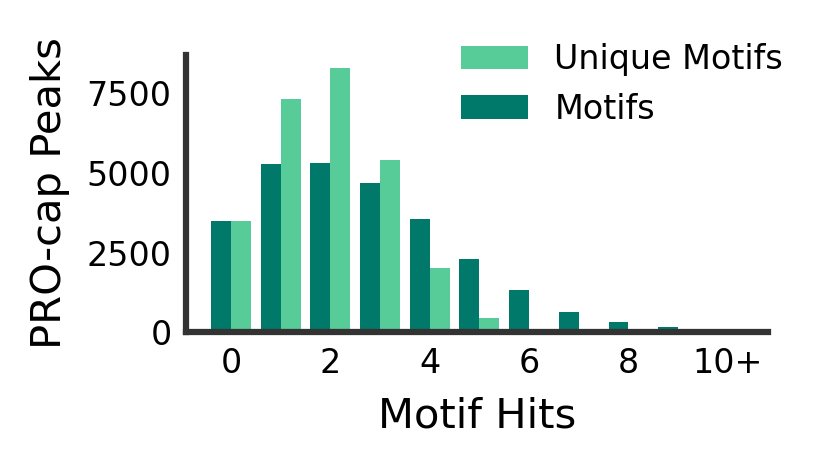

In [56]:
def plot_motif_complexity(motif_hit_counts):
    plt.figure(figsize=(2.5,1.2), dpi=300)
    bar_width = 0.4
    
    # non-unique motif hits
    motif_hits_per_peak = motif_hit_counts.sum(axis=1)
    hist_y, hist_x = np.histogram(motif_hits_per_peak, bins=range(np.max(motif_hits_per_peak) + 2))
    stop_point = 10
    hist_y = list(hist_y[:stop_point]) + [np.sum(hist_y[stop_point:])]
    hist_x = list(hist_x[:stop_point]) + [stop_point]
    
    plt.bar(hist_x, hist_y, color="#00796b", alpha=1, width=bar_width, label="Motifs")
    
    # unique motif hits
    uniq_hits_per_peak = (motif_hit_counts > 0).sum(axis=-1).astype(np.int32)
    hist_y2, hist_x2 = np.histogram(uniq_hits_per_peak, bins=range(np.max(uniq_hits_per_peak) + 2))
    stop_point2 = 9
    hist_y2 = list(hist_y2[:stop_point2]) + [np.sum(hist_y2[stop_point2:])]
    hist_x2 = np.array(list(hist_x2[:stop_point2]) + [stop_point2])
    
    plt.bar(hist_x2 + bar_width, hist_y2, color="#57cc99", alpha=1, width=bar_width, label="Unique Motifs")
    
    plt.xlabel("Motif Hits", fontsize=10)
    plt.ylabel("PRO-cap Peaks", fontsize=10)
    
    xticklabels = []
    for i in hist_x:
        if i < stop_point:
            xticklabels.append(str(i))
        else:
            xticklabels.append(str(stop_point) + "+")
            
    plt.xticks(np.array(hist_x[::2]) + bar_width / 2, xticklabels[::2])
    plt.xlim(-0.7, len(hist_x))
    plt.tick_params("both", length=0, labelsize=8)
    
    ax = plt.gca()
    ax.spines["left"].set_linewidth(1.5)
    ax.spines["bottom"].set_linewidth(1.5)
    ax.spines["left"].set_color("#333333")
    ax.spines["bottom"].set_color("#333333")
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    
    #plt.legend(frameon=False, bbox_to_anchor=(0.5,1.65), loc="upper center", fontsize=10)
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[::-1], labels[::-1], frameon=False, fontsize=8, bbox_to_anchor=(0.75,1.15), loc="upper center")
    
    plt.show()
    
plot_motif_complexity(motif_hit_counts["profile"])

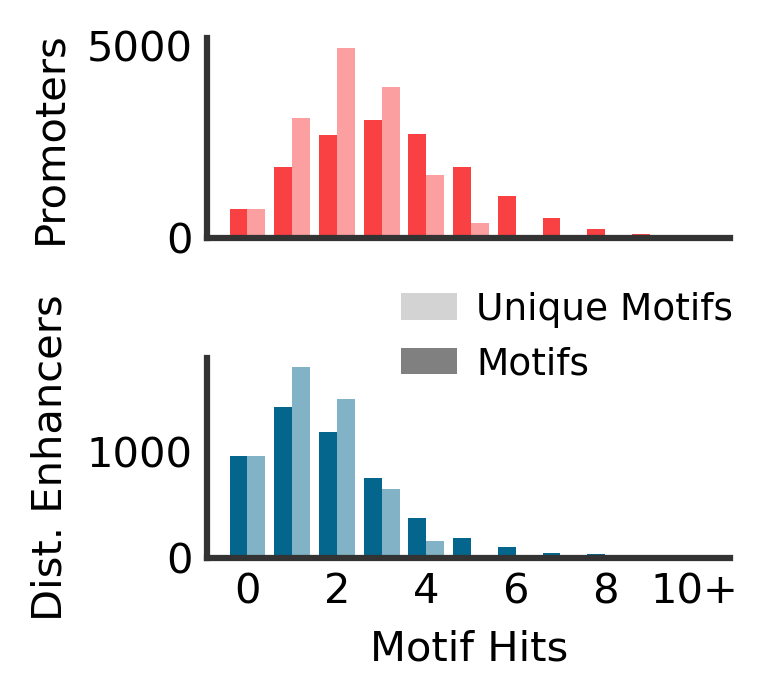

In [142]:
from matplotlib.patches import Patch


def plot_motif_complexity_across_ccres(motif_hit_counts, ccre_annots, annots_to_plot = ["PLS", "dELS"]):
    bar_width = 0.4
    
    annots_to_colors = {"All Peaks" : "gray", "PLS" : "#f94144", "dELS" : "#05668d"}

    annots_to_labels = {"PLS" : "Promoters",
                        "pELS" : "Proximal Enhancers",
                        "dELS" : "Dist. Enhancers"}
    
    
    fig, axes = plt.subplots(2, 1, figsize=(2.25,2.25), dpi=300, sharex=True)
    fig.subplots_adjust(hspace=0.6)
    
    for ax_i, key in enumerate(annots_to_plot):
        motif_hit_counts_annot = motif_hit_counts[ccre_annots[key]]
        
        # total motif hits
        
        motif_hits_per_peak = motif_hit_counts_annot.sum(axis=1)

        hist_y, hist_x = np.histogram(motif_hits_per_peak, bins=range(np.max(motif_hits_per_peak) + 2))

        stop_point = 10
        hist_y = list(hist_y[:stop_point]) + [np.sum(hist_y[stop_point:])]
        hist_x = list(hist_x[:stop_point]) + [stop_point]

        uniq_hits_per_peak = (motif_hit_counts_annot > 0).sum(axis=1)

        hist_y2, hist_x2 = np.histogram(uniq_hits_per_peak, bins=range(np.max(uniq_hits_per_peak) + 2))
        
        
        
        axes[ax_i].bar(hist_x, hist_y, color=annots_to_colors[key], width=bar_width)
        axes[ax_i].bar(hist_x2[:-1] + bar_width, hist_y2, color=annots_to_colors[key], width=bar_width, alpha=0.5)

        
        axes[ax_i].set_ylabel(annots_to_labels[key], fontsize=10)
        
        if ax_i == len(annots_to_plot) - 1:
            axes[ax_i].set_xlabel("Motif Hits", fontsize=10)
        
            xticklabels = []
            for i in hist_x:
                if i < stop_point:
                    xticklabels.append(str(i))
                else:
                    xticklabels.append(str(stop_point) + "+")

            axes[ax_i].set_xticks(np.array(hist_x[::2]) + bar_width / 2, xticklabels[::2])
            axes[ax_i].set_xlim(-0.7, len(hist_x))
            
        axes[ax_i].tick_params("both", length=0)

        axes[ax_i].spines[["left", "bottom"]].set_linewidth(1.5)
        axes[ax_i].spines[["left", "bottom"]].set_color("#333333")
        axes[ax_i].spines[["top", "right"]].set_visible(False)


    legend_elements = [Patch(facecolor='lightgray', label='Unique Motifs'),
                       Patch(facecolor='gray', label='Motifs')]

    axes[-1].legend(handles=legend_elements, fontsize=9, bbox_to_anchor=(0,0,1.07,1.5),
                   loc='upper right', frameon=False, handletextpad=0.5, handlelength=1.5)
            
    plt.show()


plot_motif_complexity_across_ccres(motif_hit_counts["profile"], ccre_annots)

In [57]:
from data_loading import one_hot_encode
from modiscolite_utils import load_sequences

onehot_seqs = load_sequences(genome_path,
                             chrom_sizes,
                             peak_path,
                             slice_len=slice_len,
                             in_window=in_window)

Loading genome sequence from /mnt/lab_data2/kcochran/new_procap_models/genomes/hg38.withrDNA.fasta
== In Extract Sequences ==
Peak filepath: /mnt/lab_data2/kcochran/new_procap_models/deepshap_out/procap/K562/strand_merged_umap/2022-10-05_03-39-32_in/peaks_uni_and_bi_train_and_val.bed.gz
Sequence length: 2114
Num. Examples: 27000


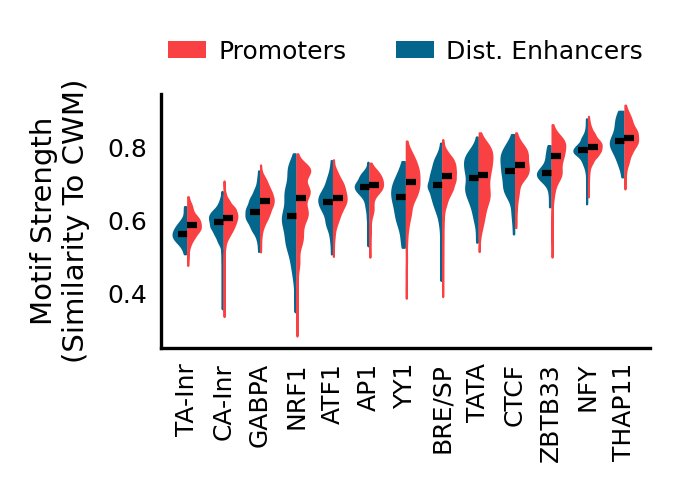

In [180]:
from report_utils import load_modisco_results, compute_per_position_ic
from other_motif_utils import trim_motif_by_ic

from matplotlib.patches import Patch


def score_seq_by_cwm(cwm, seq):
    if type(seq) == str:
        seq = one_hot_encode(seq)
    return np.multiply(seq, cwm).sum()


def extract_seqs_at_motifs(motif_hits, coords, onehot_seqs, in_window, buffer_width = 200):
        
    def convert_motif_coords_to_seq_coords(coords, coord_indexes, motif_starts, motif_ends):
        real_starts = []
        real_ends = []
        for peak_index, start, end in zip(coord_indexes, motif_starts, motif_ends):
            peak_coords = coords[peak_index]
            peak_start, peak_end = peak_coords[1:3]
            real_start = start - peak_start - (in_window - onehot_seqs.shape[1]) // 2
            real_starts.append(real_start)
            real_ends.append(real_start + (end - start))

        return np.array(real_starts), np.array(real_ends)
        
    coord_indexes = motif_hits["peak_index"]
    motif_starts = motif_hits["start"]
    motif_ends = motif_hits["end"]
    motif_rcs = motif_hits["strand"] == "-"
    
    motif_starts, motif_ends = convert_motif_coords_to_seq_coords(coords, coord_indexes,
                                                                  motif_starts, motif_ends)
    
    # For each seqlet, fetch the sequence
    motif_seqs = []
    for coord_index, motif_start, motif_end, rc in zip(coord_indexes, motif_starts, motif_ends, motif_rcs):
        motif_mid = (motif_start + motif_end) // 2
        if not (motif_mid - buffer_width < 0 or motif_mid + buffer_width > onehot_seqs.shape[1]):
            seq = onehot_seqs[coord_index, motif_start:motif_end]
            if rc:
                seq = seq[::-1, ::-1]
            motif_seqs.append(seq)

    if len(motif_seqs) == 0:
        print("oh no")
        return np.array([])
    
    motif_seqs = np.stack(motif_seqs)
    return motif_seqs


def calc_motif_strengths(modisco_results_path, onehot_seqs, patterns_to_keep,
                         motif_hits, coords, in_window, prof_width=200):

    modisco_results = load_modisco_results(modisco_results_path)
    
    pattern_type = "pos_patterns"
    patterns = modisco_results[pattern_type]

    cwm_score_list = []
    for ax_row_i, pattern_i in enumerate(patterns_to_keep):
        pattern_name = "pattern_" + str(pattern_i)
        pattern = patterns[pattern_name]
        
        # need to trim here because the hit caller trimmed
        # but this just trims from 30 to 25
        cwm_trimmed = trim_motif_by_ic(pattern["contrib_scores"][:], pattern["sequence"][:])
        cwm_trimmed = cwm_trimmed / np.sum(cwm_trimmed)
        
        # do ax_row_i here because the motif hit caller only saw filtered subset of motifs
        motif_hits_subset = motif_hits[motif_hits["key"] == ax_row_i]

        motif_seqs = extract_seqs_at_motifs(motif_hits_subset, coords,
                                            onehot_seqs, in_window, buffer_width=prof_width)
        seq_scores = np.array([score_seq_by_cwm(cwm_trimmed, seq) for seq in motif_seqs])
        cwm_score_list.append(seq_scores)
        
    return cwm_score_list


def subset_motif_hits_by_ccre(motif_hits, ccre_bools):
    peak_indexes_with_ccre = np.where(ccre_bools)[0]
    return motif_hits[motif_hits["peak_index"].isin(peak_indexes_with_ccre)]


def make_violinplot_halved(violinplot, color, left=False):
    for b in violinplot['bodies']:
        # get the center
        m = np.mean(b.get_paths()[0].vertices[:, 0])
        
        if left:
            # modify the paths to not go further right than the center
            b.get_paths()[0].vertices[:, 0] = np.clip(b.get_paths()[0].vertices[:, 0], - np.inf, m)
        else:
            # modify the paths to not go further left than the center
            b.get_paths()[0].vertices[:, 0] = np.clip(b.get_paths()[0].vertices[:, 0], m, np.inf)

        b.set_edgecolor(color)
        b.set_facecolor(color)
        b.set_alpha(1)
        b.set_linewidth(0.5)
        
        
def plot_motif_strengths_by_ccre(modisco_results_path, onehot_seqs,
                                 patterns_to_keep, motif_hits, coords,
                                 in_window, ccre_annots):
    
    annots_to_colors = {"All Peaks" : "gray", "PLS" : "#f94144", "dELS" : "#05668d"}

    annots_to_labels = {"PLS" : "Promoters",
                        "pELS" : "Proximal Enhancers",
                        "dELS" : "Distal Enhancers"}
    
    all_motif_strengths = dict()
    median_motif_strengths = dict()
    
    for annot in ["PLS", "dELS"]:
        motif_hits_for_annot = subset_motif_hits_by_ccre(motif_hits, ccre_annots[annot])

        motif_strengths = calc_motif_strengths(modisco_results_path, onehot_seqs,
                                               patterns_to_keep, motif_hits_for_annot,
                                               coords, in_window)
        all_motif_strengths[annot] = np.array(motif_strengths, dtype=object)
        median_motif_strengths[annot] = np.array([np.median(strengths) for strengths in motif_strengths])
    
    plot_order = np.argsort(median_motif_strengths["PLS"])
    num_motifs = len(all_motif_strengths["PLS"])
    
    
    plt.figure(figsize=(2.1,1.1), dpi=300)

    v2 = plt.violinplot(all_motif_strengths["dELS"][plot_order], points=500,
                       positions=np.arange(num_motifs) - 0.03,
                       showmeans=False, showextrema=False, showmedians=False,
                       widths=0.7)
    
    make_violinplot_halved(v2, annots_to_colors["dELS"], left=True)

    plt.scatter(np.arange(num_motifs) - 0.12, median_motif_strengths["dELS"][plot_order],
                marker="_", c="k", s=5, zorder=1)
    
    
    v1 = plt.violinplot(all_motif_strengths["PLS"][plot_order], points=500,
                       positions=np.arange(num_motifs) + 0.02,
                       showmeans=False, showextrema=False, showmedians=False,
                       widths=0.7)
    
    make_violinplot_halved(v1, annots_to_colors["PLS"])

    plt.scatter(np.arange(num_motifs) + 0.14, median_motif_strengths["PLS"][plot_order],
                marker="_", c="k", s=5, zorder=1)
    
    plt.ylabel("Motif Strength\n(Similarity To CWM)", fontsize=7)
    
    plt.xticks(np.arange(num_motifs), np.array(motif_keys_to_labels)[plot_order],
               rotation=90, fontsize=6)
    
    plt.tick_params("both", length=0)
    plt.tick_params("y", labelsize=6)
    plt.xlim(-0.7, num_motifs - 0.3)
    
    plt.gca().spines[["top", "right"]].set_visible(False)

    legend_elements = [Patch(facecolor=annots_to_colors["PLS"], label='Promoters'),
                       Patch(facecolor=annots_to_colors["dELS"], label='Dist. Enhancers')]

    plt.legend(handles=legend_elements, fontsize=6, bbox_to_anchor=(0.5, 1.03), ncol=2,
                   loc='lower center', frameon=False, handletextpad=0.5, handlelength=1.5)
    
    plt.show()
        
        
plot_motif_strengths_by_ccre(modisco_results_path, onehot_seqs,
                             patterns_to_keep, motif_hits["profile"], coords,
                             in_window, ccre_annots)

## Motif Co-occurrence Plots

In [183]:
def get_motif_jaccard_matrix(peak_hit_counts):
    peak_hit_counts = (peak_hit_counts > 0) * 1
    num_motifs = peak_hit_counts.shape[1]
    
    jaccards = np.zeros((num_motifs, num_motifs))
    for i in range(num_motifs):
        motif_i_peak_hits = peak_hit_counts[:, i]
        for j in range(i + 1, num_motifs):
            motif_j_peak_hits = peak_hit_counts[:, j]
            
            intersection = np.dot(motif_i_peak_hits, motif_j_peak_hits)
            union = np.sum((motif_i_peak_hits + motif_j_peak_hits) > 0)
            jaccards[i, j] = intersection / union
            jaccards[j, i] = jaccards[i, j]
            
    return jaccards

def combine_two_symmetric_matrices(matrix1, matrix2):
    assert matrix1.shape == matrix2.shape, (matrix1.shape, matrix2.shape)
    assert len(matrix1.shape) == 2 and matrix1.shape[0] == matrix1.shape[1], matrix1.shape
    
    # matrix1 will be lower left half, matrix2 will be upper right
    
    dim = matrix1.shape[0]
    combo_matrix = np.full((dim, dim), np.nan)
    
    for i in range(dim):
        for j in range(dim):
            if i == j:
                continue
            elif i > j:
                combo_matrix[i,j] = matrix1[i,j]
            else:
                combo_matrix[i,j] = matrix2[i,j]
                
    return combo_matrix
    

promoter_motif_jaccard_matrix = get_motif_jaccard_matrix(motif_hit_counts["profile"][ccre_annots["PLS"]])
enhancer_motif_jaccard_matrix = get_motif_jaccard_matrix(motif_hit_counts["profile"][ccre_annots["dELS"]])
combo_jaccard_matrix = combine_two_symmetric_matrices(promoter_motif_jaccard_matrix,
                                                      enhancer_motif_jaccard_matrix)

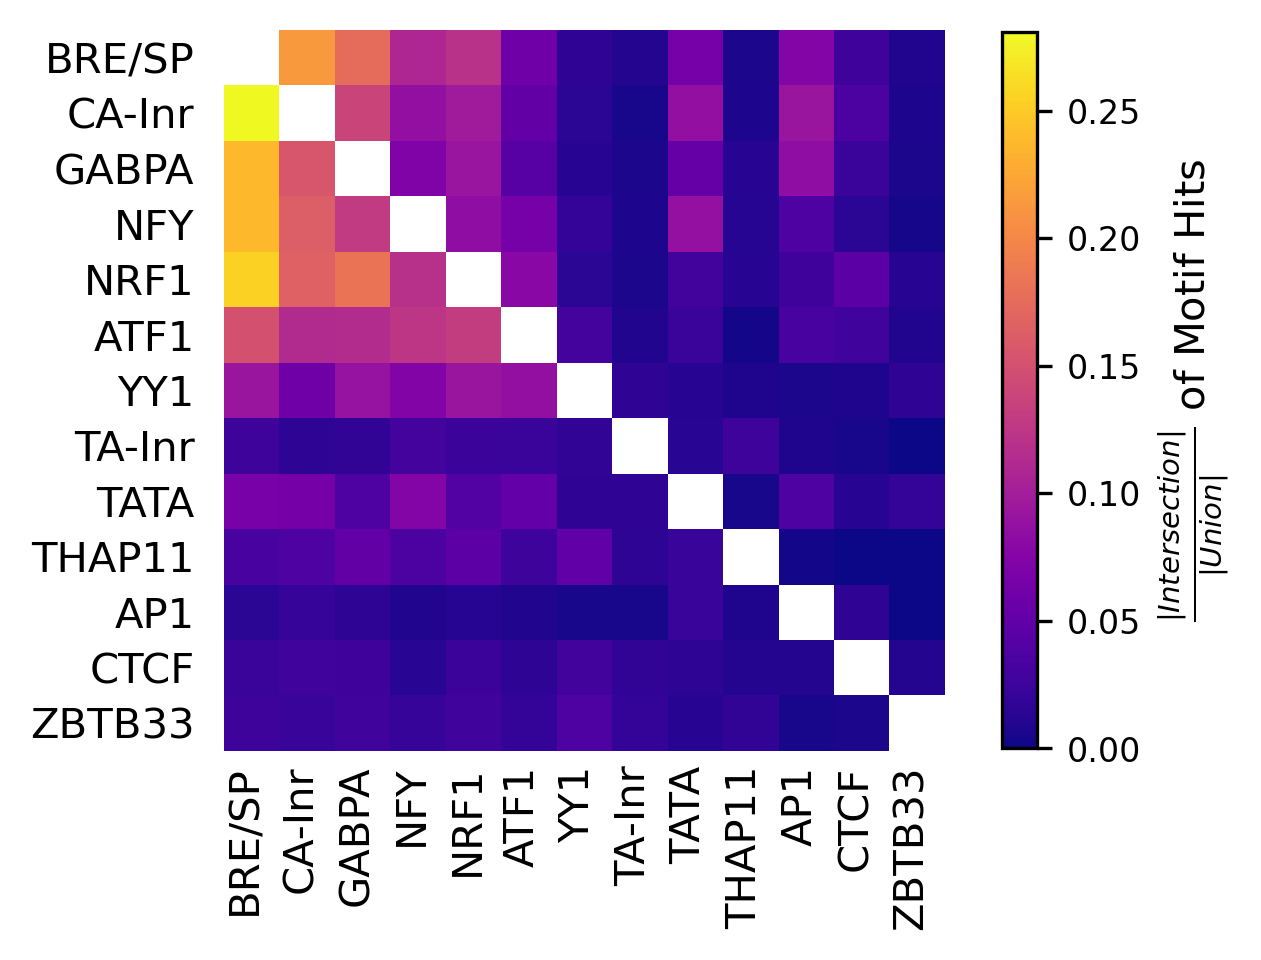

In [184]:
from plot_utils import get_continuous_cmap
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection


def get_upper_right_highlight_coords(n_rows):
    # assuming n_rows = n_cols
    # want (5.5, 0.5), (4.5, 0.5), (4.5, 1.5), ..., (0.5, 5.5)
    
    curr_x = 0.5
    curr_y = -0.5
    
    coords_list = [(curr_x, curr_y)]
    while curr_x < n_rows - 0.5:
        curr_y += 1
        coords_list.append((curr_x, curr_y))
        curr_x += 1
        coords_list.append((curr_x, curr_y))
        
    coords_list.append((n_rows - 0.5, -0.5))
    coords_list.append(coords_list[0])  # back to start
    
    return np.array(coords_list)


def plot_jaccard_matrix(jaccard_matrix, inds=None):
    num_motifs = jaccard_matrix.shape[0]
    
    if inds is not None:
        assert len(inds) == num_motifs, inds
        jaccard_matrix = jaccard_matrix[inds][:, inds]
        ticklabels = [k + 1 for k in inds]
    else:
        ticklabels = range(num_motifs)
    
    ticklabels = [motif_keys_to_labels[i] for i in ticklabels]
    
    plt.figure(figsize=(3.5,3.5), dpi=300)
    plt.imshow(jaccard_matrix, cmap="plasma")
    
    ax = plt.gca()
    
    for side in ["top", "right", "bottom", "left"]:
        ax.spines[side].set_visible(False)
    
    ax.tick_params("x", length=0, color="w")
    ax.tick_params("y", color="none")

    ticks = np.arange(num_motifs)
    ax.set_xticks([n - 0.1 for n in ticks], ticklabels, rotation=90)
    ax.set_yticks(ticks, ticklabels)

    cbar = plt.colorbar(label=r'$\frac{|Intersection|}{|Union|}$ of Motif Hits',
                        fraction=0.044, pad=0.07)
    cbar.ax.tick_params(labelsize=8)
    
    plt.show()
    
    
plot_jaccard_matrix(combo_jaccard_matrix)

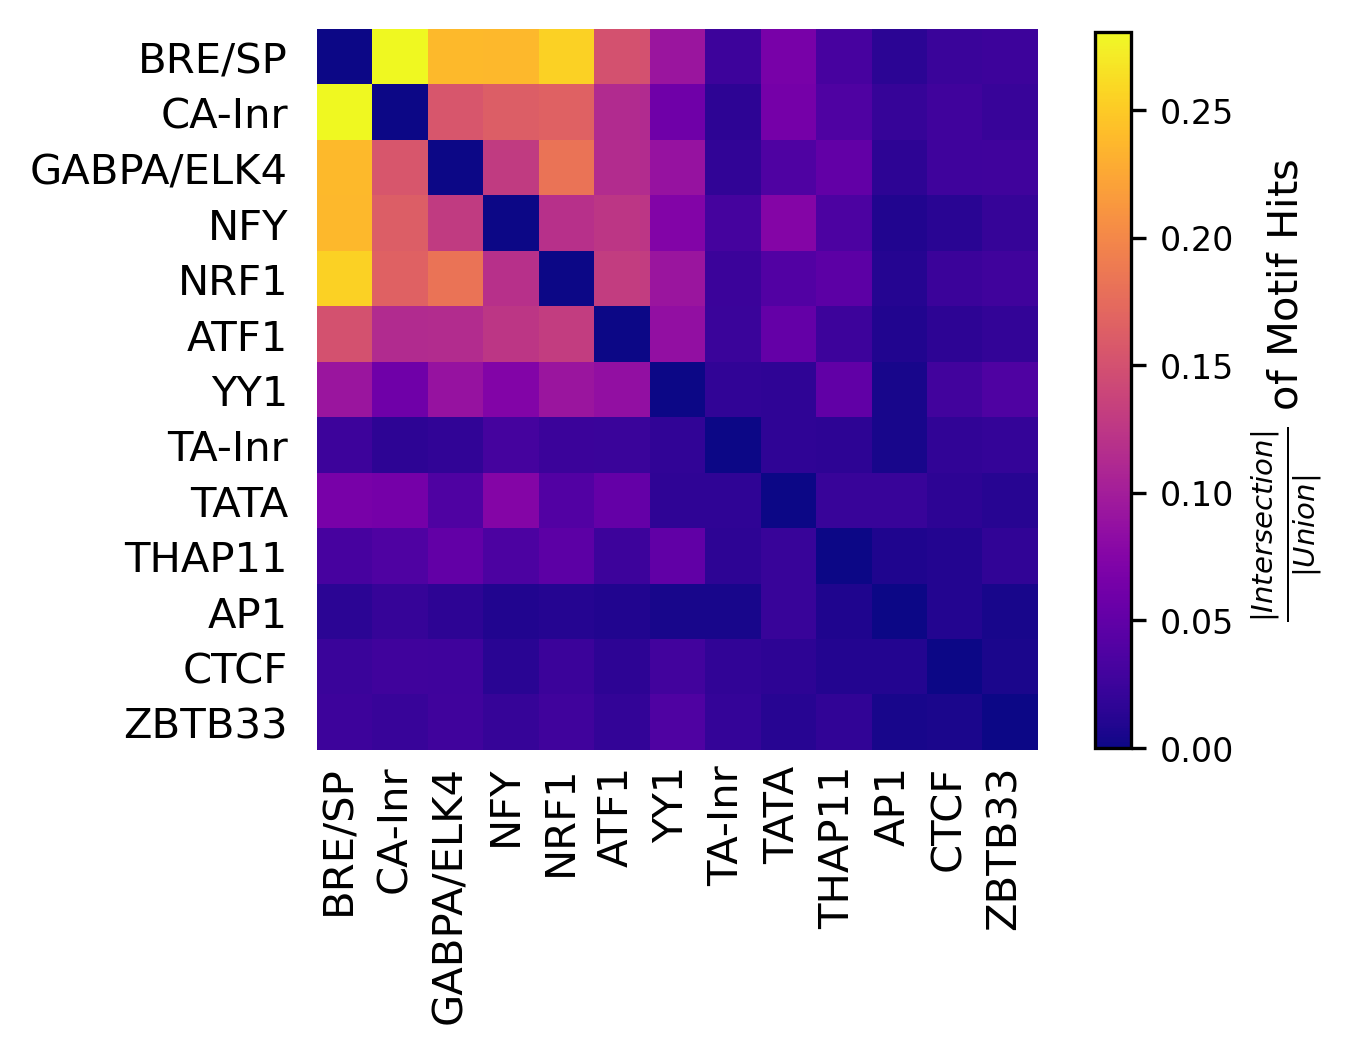

In [227]:
# sanity check which corner is the promoters corner:
plot_jaccard_matrix(promoter_motif_jaccard_matrix)

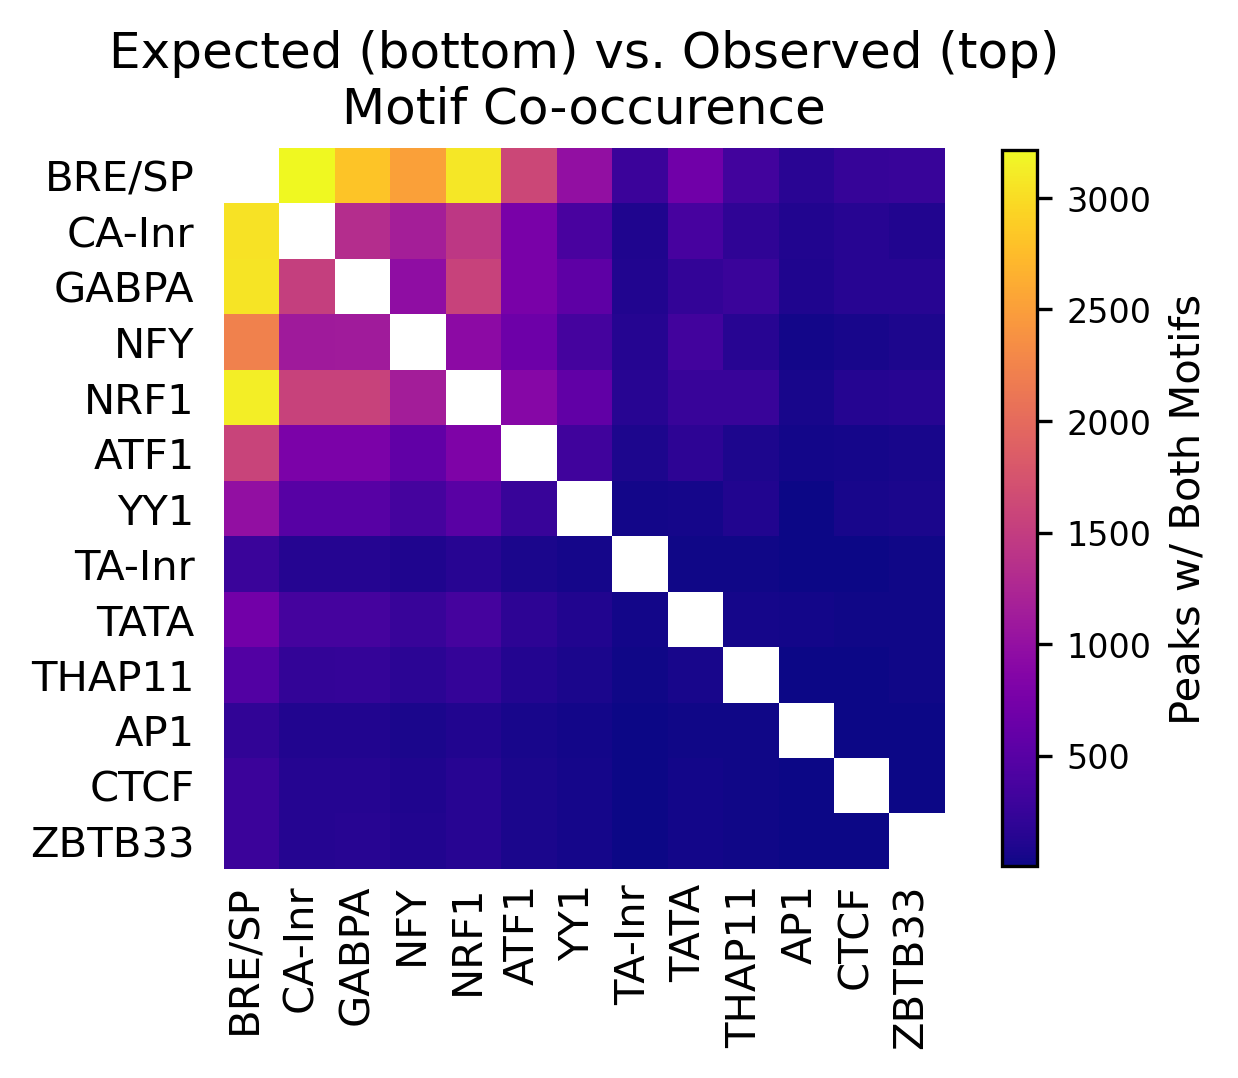

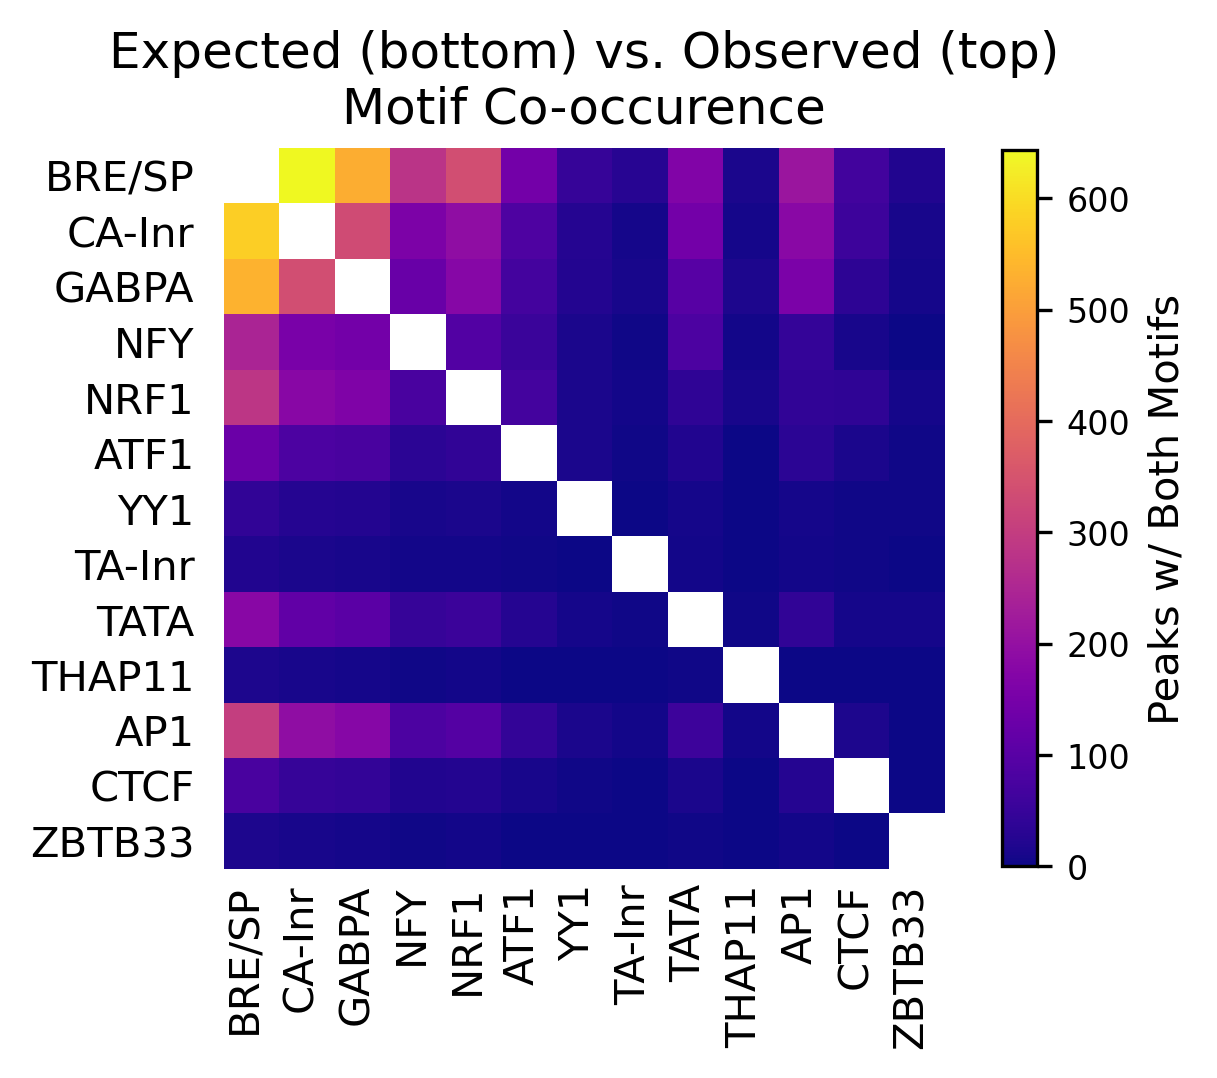

In [148]:
def plot_motif_cooccurrence(peak_hit_counts, motif_keys_to_labels = motif_keys_to_labels):
    num_motifs = len(motif_keys_to_labels)
    
    motif_counts = []
    motif_cooccur_counts = []
    
    motif_keys = range(num_motifs)
    for motif_index in motif_keys:
        peaks_with_motif = peak_hit_counts[:, motif_index] > 0
            
        motif_counts.append(np.sum(peaks_with_motif))
        
        motif_cooccur_counts_tmp = []
        for motif2_index in motif_keys:
            peaks_with_motif2 = peak_hit_counts[:, motif2_index] > 0
            
            num_peaks_both_motifs = np.sum(peaks_with_motif * peaks_with_motif2)
            motif_cooccur_counts_tmp.append(num_peaks_both_motifs)
            
        motif_cooccur_counts.append(motif_cooccur_counts_tmp)
        
    motif_fracs = np.array(motif_counts) / peak_hit_counts.shape[0]
    motif_cooccur_fracs = np.array(motif_cooccur_counts)  #/ peak_hit_counts.shape[0]

    # multiply (N,1) x (1,N) to get (N,N) matrix of expected co-occurrence
    motif_frac_matrix = np.matmul(motif_fracs[:, None], motif_fracs[None, :]) * peak_hit_counts.shape[0] ####

    combo_matrix = combine_two_symmetric_matrices(motif_frac_matrix, motif_cooccur_fracs)
    
    # plot
    
    ticklabels = range(num_motifs)
    ticklabels = [motif_keys_to_labels[i] for i in ticklabels]
    
    plt.figure(figsize=(3.5,3.5), dpi=300)
    plt.imshow(combo_matrix, cmap="plasma")
    
    ax = plt.gca()
    
    for side in ["top", "right", "bottom", "left"]:
        ax.spines[side].set_visible(False)
    
    ax.tick_params("x", length=0, color="w")
    ax.tick_params("y", color="none")

    ticks = np.arange(num_motifs)
    ax.set_xticks([n - 0.1 for n in ticks], ticklabels, rotation=90)
    ax.set_yticks(ticks, ticklabels)

    cbar = plt.colorbar(label="Peaks w/ Both Motifs",
                        fraction=0.044, pad=0.07)
    cbar.ax.tick_params(labelsize=8)
    
    plt.title("Expected (bottom) vs. Observed (top)\nMotif Co-occurence")
    plt.show()
    
    
    
plot_motif_cooccurrence(motif_hit_counts["profile"][ccre_annots["PLS"]])
plot_motif_cooccurrence(motif_hit_counts["profile"][ccre_annots["dELS"]])

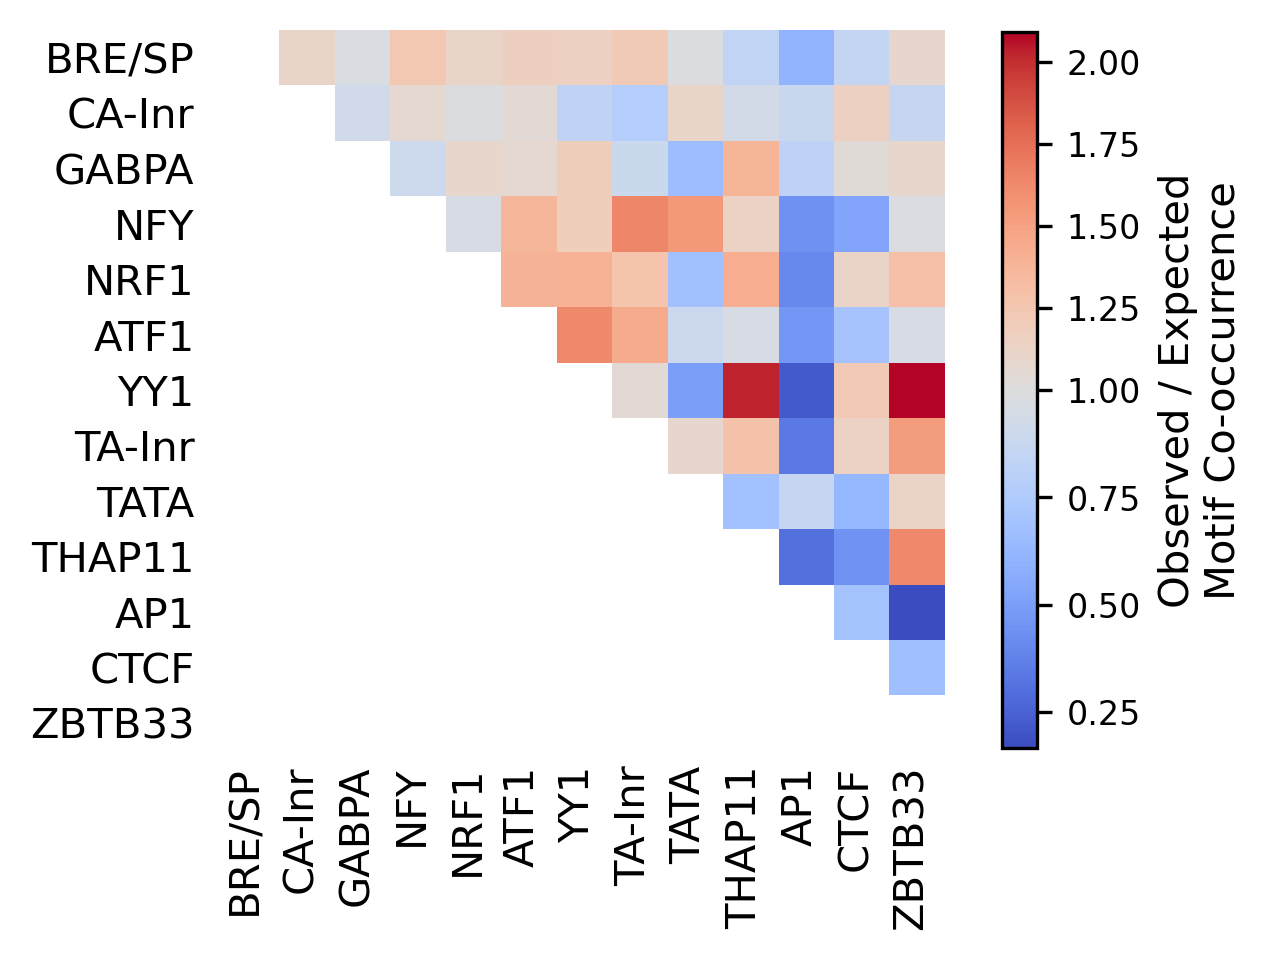

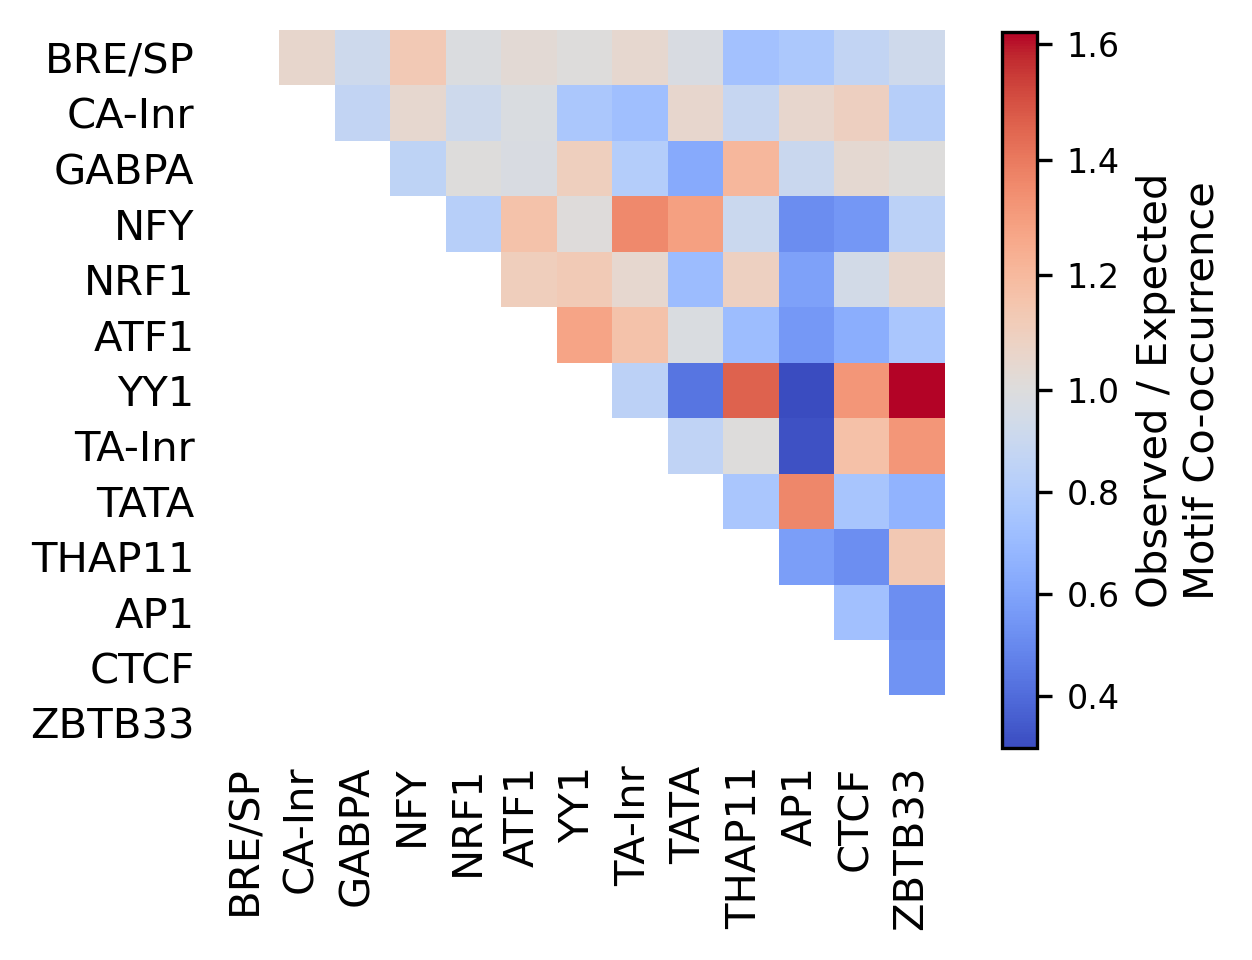

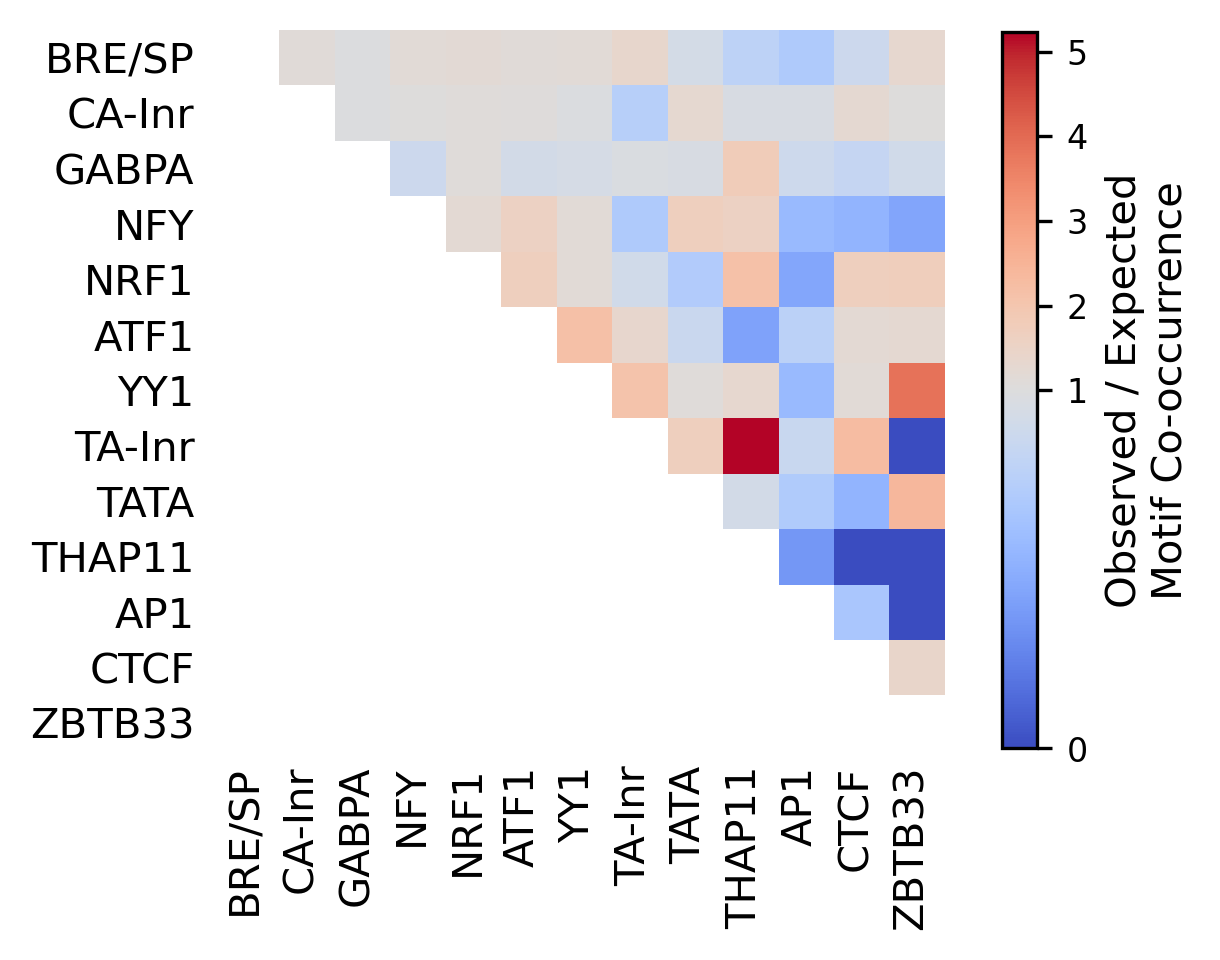

In [155]:
from collections import defaultdict
from matplotlib import colors

class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))



def combine_two_symmetric_matrices(matrix1, matrix2):
    assert matrix1.shape == matrix2.shape, (matrix1.shape, matrix2.shape)
    assert len(matrix1.shape) == 2 and matrix1.shape[0] == matrix1.shape[1], matrix1.shape
    
    # matrix1 will be lower left half, matrix2 will be upper right
    
    dim = matrix1.shape[0]
    combo_matrix = np.full((dim, dim), np.nan)
    
    for i in range(dim):
        for j in range(dim):
            if i == j:
                continue
            elif i > j:
                combo_matrix[i,j] = matrix1[i,j]
            else:
                combo_matrix[i,j] = matrix2[i,j]
                
    return combo_matrix


def plot_motif_cooccurrence(peak_hit_counts, motif_keys_to_labels = motif_keys_to_labels):
    num_motifs = len(motif_keys_to_labels)
    
    motif_counts = []
    motif_cooccur_counts = []
    
    motif_keys = range(num_motifs)
    for motif_index in motif_keys:
        peaks_with_motif = peak_hit_counts[:, motif_index] > 0
            
        motif_counts.append(np.sum(peaks_with_motif))
        
        motif_cooccur_counts_tmp = []
        for motif2_index in motif_keys:
            peaks_with_motif2 = peak_hit_counts[:, motif2_index] > 0
            
            num_peaks_both_motifs = np.sum(peaks_with_motif * peaks_with_motif2)
            motif_cooccur_counts_tmp.append(num_peaks_both_motifs)
            
        motif_cooccur_counts.append(motif_cooccur_counts_tmp)
        
    motif_fracs = np.array(motif_counts) / peak_hit_counts.shape[0]
    motif_cooccur_fracs = np.array(motif_cooccur_counts)  / peak_hit_counts.shape[0]

    # multiply (N,1) x (1,N) to get (N,N) matrix of expected co-occurrence
    motif_frac_matrix = np.matmul(motif_fracs[:, None], motif_fracs[None, :])

    motif_cooccur_enrichment = motif_cooccur_fracs / motif_frac_matrix
    
    combo_matrix = combine_two_symmetric_matrices(np.full_like(motif_frac_matrix, np.nan),
                                                  motif_cooccur_enrichment)
    
    # plot
    
    ticklabels = range(num_motifs)
    ticklabels = [motif_keys_to_labels[i] for i in ticklabels]
    
    plt.figure(figsize=(3.5,3.5), dpi=300)
    plt.imshow(combo_matrix, cmap="coolwarm", norm=colors.TwoSlopeNorm(vmin=np.min(combo_matrix[~np.isnan(combo_matrix)]),
                                                                       vcenter=1.,
                                        vmax=np.max(combo_matrix[~np.isnan(combo_matrix)])))
    
    ax = plt.gca()
    
    for side in ["top", "right", "bottom", "left"]:
        ax.spines[side].set_visible(False)
    
    ax.tick_params("x", length=0, color="w")
    ax.tick_params("y", color="none")

    ticks = np.arange(num_motifs)
    ax.set_xticks([n - 0.1 for n in ticks], ticklabels, rotation=90)
    ax.set_yticks(ticks, ticklabels)

    cbar = plt.colorbar(label="Observed / Expected\nMotif Co-occurrence",
                        fraction=0.044, pad=0.07)
    cbar.ax.tick_params(labelsize=8)
    
    plt.show()
    
    
plot_motif_cooccurrence(motif_hit_counts["profile"])
    
    
plot_motif_cooccurrence(motif_hit_counts["profile"][ccre_annots["PLS"]])
plot_motif_cooccurrence(motif_hit_counts["profile"][ccre_annots["dELS"]])

/tmp/ipykernel_14713/1146164121.py:57: RuntimeWarning: divide by zero encountered in log10
  neg_log_pvals = - np.log10(compute_cooccurrence_pvals(peak_hit_counts))


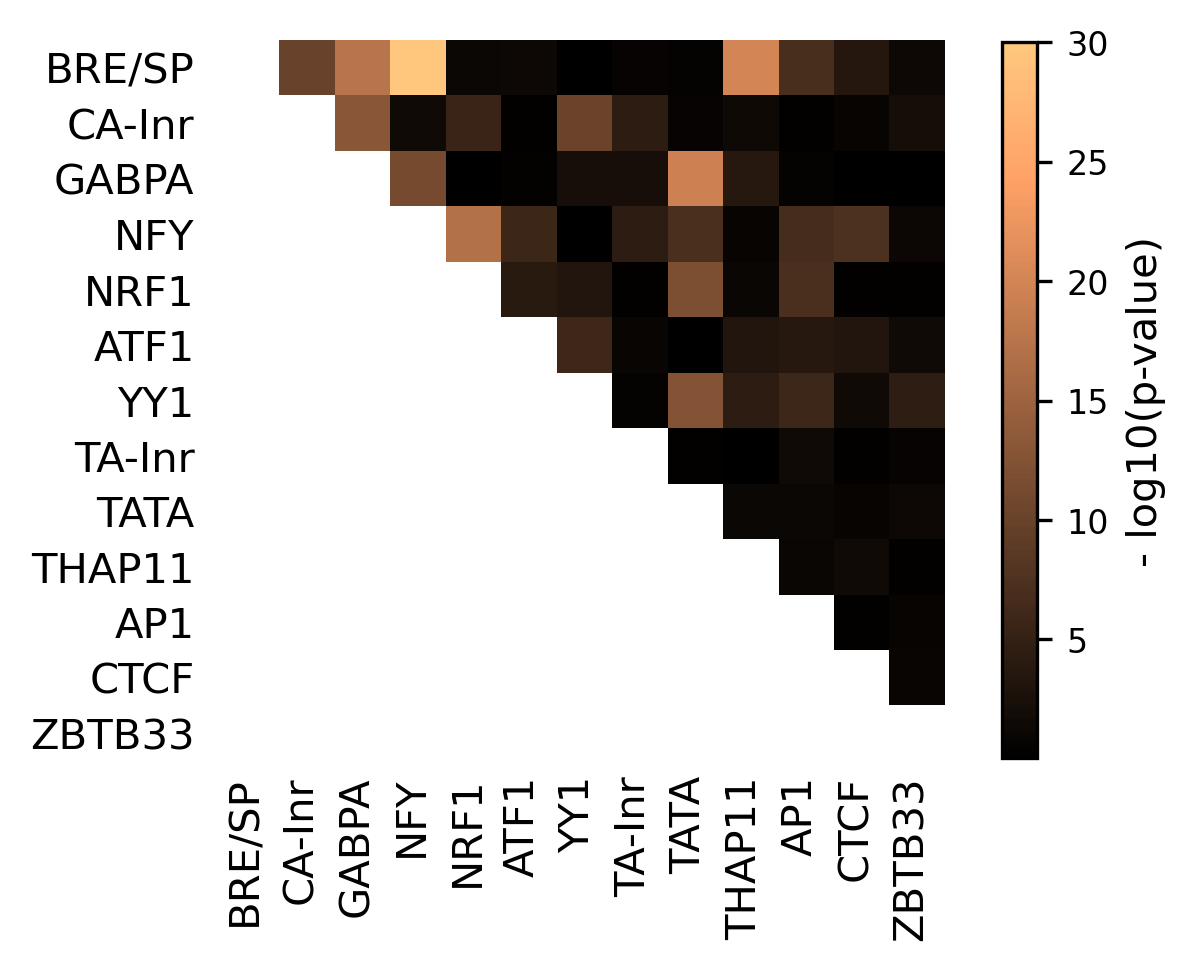

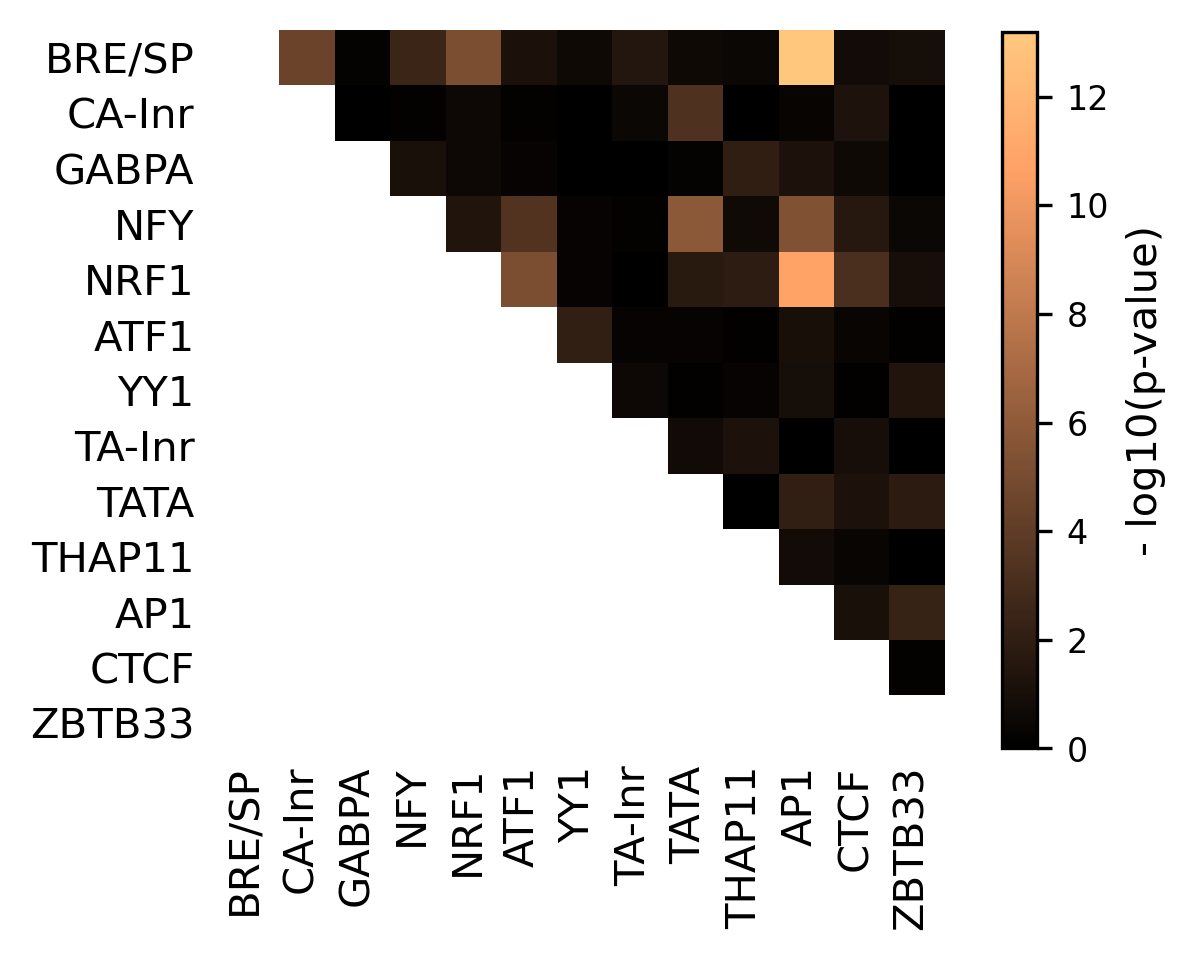

In [156]:
import scipy

def compute_cooccurrence_pvals(peak_hit_counts):
    """
    Given the number of motif hits in each peak, computes p-value of
    co-occurrence for each pair of motifs, including self pairs.
    Returns an M x M array of p-values for the M motifs.
    """
    peak_hit_indicators = (peak_hit_counts > 0).astype(int)
    num_peaks, num_motifs = peak_hit_counts.shape
    
    pvals = np.ones((num_motifs, num_motifs))
    
    # Significance is based on a Fisher's exact test. If the motifs were
    # present in peaks randomly, we'd independence of occurrence.
    # For self-co-occurrence, the null model is not independence, but
    # collisions
    for i in range(num_motifs):
        for j in range(i):
            pair_counts = peak_hit_indicators[:, [i, j]]
            peaks_with_1 = pair_counts[:, 0] == 1
            peaks_with_2 = pair_counts[:, 1] == 1
            # Contingency table (universe is set of all peaks):
            #              no motif 1  |  has motif 1
            # no motif 2       A       |      B
            # -------------------------+--------------
            # has motif 2      C       |      D
            # The Fisher's exact test evaluates the significance of the
            # association between the two classifications
            cont_table = np.array([
                [
                    np.sum(~(peaks_with_1) & (~peaks_with_2)),
                    np.sum(peaks_with_1 & (~peaks_with_2))
                ],
                [
                    np.sum(~(peaks_with_1) & peaks_with_2),
                    np.sum(peaks_with_1 & peaks_with_2)
                ]
            ])
            pval = scipy.stats.fisher_exact(
                cont_table, alternative="two-sided"
            )[1]
            pvals[i, j] = pval
            pvals[j, i] = pval

        # Self-co-occurrence: Poissonize balls in bins
        # Expected number of collisions (via linearity of expectations):
        num_hits = np.sum(peak_hit_indicators[:, i])  # number of "balls"
        expected_collisions = num_hits * (num_hits - 1) / (2 * num_peaks)
        num_collisions = np.sum(peak_hit_counts[:, i] >= 2)
        pval = 1 - scipy.stats.poisson.cdf(num_collisions, mu=expected_collisions)
        pvals[i, i] = pval
    
    return pvals

def plot_pvals(peak_hit_counts, motif_keys_to_labels = motif_keys_to_labels):
    neg_log_pvals = - np.log10(compute_cooccurrence_pvals(peak_hit_counts))
    
    #neg_log_pvals[neg_log_pvals < 5] = np.nan
    
    matrix_to_plot = combine_two_symmetric_matrices(np.full_like(neg_log_pvals, np.nan),
                                                    neg_log_pvals)
    
    num_motifs = len(motif_keys_to_labels)
    ticklabels = range(num_motifs)
    ticklabels = [motif_keys_to_labels[i] for i in ticklabels]
    
    plt.figure(figsize=(3.5,3.5), dpi=300)
    plt.imshow(matrix_to_plot, cmap="copper")
    
    ax = plt.gca()
    
    for side in ["top", "right", "bottom", "left"]:
        ax.spines[side].set_visible(False)
    
    ax.tick_params("x", length=0, color="w")
    ax.tick_params("y", color="none")

    ticks = np.arange(num_motifs)
    ax.set_xticks([n - 0.1 for n in ticks], ticklabels, rotation=90)
    ax.set_yticks(ticks, ticklabels)

    cbar = plt.colorbar(label="- log10(p-value)",
                        fraction=0.044, pad=0.07)
    cbar.ax.tick_params(labelsize=8)
    
    plt.show()
    

plot_pvals(motif_hit_counts["profile"][ccre_annots["PLS"]])
plot_pvals(motif_hit_counts["profile"][ccre_annots["dELS"]])

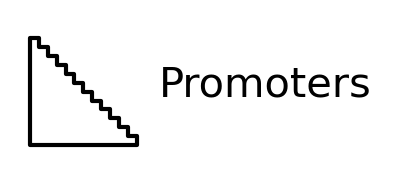

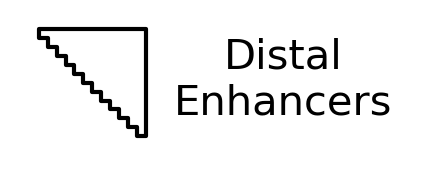

In [238]:
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection


def drew_legend_for_heatmap(combo_jaccard_matrix, promoters=True):
    dim = len(combo_jaccard_matrix)
    
    blank_map = np.full((dim, dim), np.nan)
    
    plt.figure(figsize=(0.5,0.5), dpi=300)
    cmap = get_continuous_cmap(["#3B1F68", "#5F31A6", "#B197DA"])  # doesn't matter
    cmap.set_bad('white',1.)
    plt.imshow(blank_map, cmap=cmap)
    
    ax = plt.gca()
    
    upper_right_highlight_coords = get_upper_right_highlight_coords(dim)
    if promoters:
        upper_right_highlight_coords = upper_right_highlight_coords[:, ::-1]
    upper_right_highlight = Polygon(upper_right_highlight_coords)
    ax.add_collection(PatchCollection([upper_right_highlight],
                                      color="k", facecolor="none",
                                      linewidth=1, clip_on=False))
    
    if promoters:
        ax.text(dim * 2, dim -5,
                "Promoters",
                ha="center", va="bottom", color="k", fontsize=10)
    else:
        ax.text(dim * 2+2, dim - 3,
                "Distal\nEnhancers",
                ha="center", va="bottom", color="k", fontsize=10)
    
    for side in ["top", "right", "bottom", "left"]:
        ax.spines[side].set_visible(False)
    plt.xticks([])
    plt.yticks([])
    
    plt.show()
    
    
drew_legend_for_heatmap(combo_jaccard_matrix, promoters=True)
drew_legend_for_heatmap(combo_jaccard_matrix, promoters=False)

In [152]:
from other_motif_utils import trim_motif_by_ic

def extract_seqs_at_motifs(motif_hits, coords, onehot_seqs, in_window, buffer_width = 0):
        
    ### DIFFERENT FROM FIG2: because the onehot_seqs here are in_window length   #############!!!!!!!!!!!!
    # Or maybe actually it's fine because of the "(in_window - onehot_seqs.shape[1]) // 2" ?
    
    def convert_motif_coords_to_seq_coords(coords, coord_indexes, motif_starts, motif_ends):
        real_starts = []
        real_ends = []
        for peak_index, start, end in zip(coord_indexes, motif_starts, motif_ends):
            peak_coords = coords[peak_index]
            peak_start, peak_end = peak_coords[1:3]
            real_start = start - peak_start - (in_window - onehot_seqs.shape[1]) // 2
            real_starts.append(real_start)
            real_ends.append(real_start + (end - start))
            #print(peak_start, peak_end, start, end, real_start)
        return np.array(real_starts), np.array(real_ends)
        
    coord_indexes = motif_hits["peak_index"]
    motif_starts = motif_hits["start"]
    motif_ends = motif_hits["end"]
    motif_rcs = motif_hits["strand"] == "-"
    
    motif_starts, motif_ends = convert_motif_coords_to_seq_coords(coords, coord_indexes,
                                                                  motif_starts, motif_ends)
    
    # For each seqlet, fetch the sequence
    motif_seqs = []
    for coord_index, motif_start, motif_end, rc in zip(coord_indexes, motif_starts, motif_ends, motif_rcs):
        motif_mid = (motif_start + motif_end) // 2
        if not (motif_mid - buffer_width < 0 or motif_mid + buffer_width > onehot_seqs.shape[1]):
            seq = onehot_seqs[coord_index, motif_start:motif_end]
            if rc:
                seq = seq[::-1, ::-1]
            motif_seqs.append(seq)

    motif_seqs = np.stack(motif_seqs)
    return motif_seqs


# this is also in 5_modisco/report_utils.py
def compute_per_position_ic(ppm, background=np.array([0.25] * 4), pseudocount=0.001):
    alphabet_len = len(background)
    #ppm = np.abs(ppm)
    ic = ((np.log((ppm+pseudocount)/(1 + pseudocount*alphabet_len))/np.log(2))
          *ppm - (np.log(background)*background/np.log(2))[None,:])
    return np.sum(ic,axis=1)




#def get_ccre_bools_for_motif_hits(motif_hits, ccre_coords):
#    # for each motif hit, find out if in any ccre
    
sys.path.append("../5_modisco")
from report_utils import load_modisco_results
modisco_results = load_modisco_results(modisco_results_path)
    

def plot_affinity_across_ccres(modisco_results, onehot_seqs,
                               patterns_to_keep, motif_hits,
                               coords, ccre_annots,
                               in_window, out_window, slice_len,
                               prof_width=200):

    pattern_type = "pos_patterns"
    patterns = modisco_results[pattern_type]

    cwm_score_dict = dict()
    motif_annots_by_pattern = dict()
    for ax_row_i, pattern_i in enumerate(patterns_to_keep):
        pattern_name = "pattern_" + str(pattern_i)
        pattern = patterns[pattern_name]
        
        # need to trim here because the hit caller trimmed
        cwm_trimmed = trim_motif_by_ic(pattern["contrib_scores"][:], pattern["sequence"][:])

        # do ax_row_i here because the motif hit caller only saw filtered subset of motifs
        motif_hits_subset = motif_hits[motif_hits["key"] == ax_row_i]
        
        annots_aubset = {ccre : annots[motif_hits["key"] == ax_row_i] for ccre, annots in ccre_annots.items()}
        motif_annots_by_pattern[pattern_name] = annots_aubset
        
        motif_seqs = extract_seqs_at_motifs(motif_hits_subset, coords,
                                            onehot_seqs, in_window, buffer_width=prof_width)
        
        seq_scores = np.array([score_seq_by_cwm(cwm_trimmed, seq) for seq in motif_seqs])
        cwm_score_list[pattern_name] = seq_scores
        
    
        for key in ["PLS", "dELS"]:
            seq_scores_subset = seq_scores[annots_aubset]

            plt.hist(seq_scores_subset, label = key)
            
            plt.tick_params("both", length=0)

            ax = plt.gca()
            ax.spines["left"].set_linewidth(1.5)
            ax.spines["bottom"].set_linewidth(1.5)
            ax.spines["left"].set_color("#333333")
            ax.spines["bottom"].set_color("#333333")
            ax.spines["top"].set_visible(False)
            ax.spines["right"].set_visible(False)

        plt.show()
        
plot_affinity_across_ccres(modisco_results, onehot_seqs,
                           patterns_to_keep, motif_hits,
                           coords, motif_annots, 
                           in_window, out_window, slice_len)

ValueError: need at least one array to stack

In [134]:
motif_hits

,chrom,start,end,key,strand,peak_index,imp_total_score,imp_frac_score,agg_sim,mod_delta,mod_precision,mod_percentile,fann_perclasssum_perc,fann_perclassavg_perc
0,chr9,97238424,97238449,2,+,7870,0.152324,0.037479,0.078225,0.000116,0.966102,0.116505,0.143866,0.230362
1,chrX,152958845,152958870,1,+,22617,0.468231,0.104589,0.117022,0.000101,0.920000,0.122622,0.226216,0.399577
2,chr17,21284664,21284689,1,-,23352,0.883718,0.127130,0.120092,0.000096,0.920000,0.106765,0.200846,0.447146
3,chr7,101162978,101163003,1,-,17883,0.588780,0.147494,0.129180,0.000085,0.825000,0.073996,0.261099,0.948203
4,chr21,46458495,46458520,4,+,18744,0.289581,0.076067,0.134540,0.000086,0.966667,0.134638,0.135788,0.169160
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75683,chr6,11093689,11093714,9,+,2546,0.858662,0.192694,0.683982,0.000177,1.000000,0.823413,0.976190,0.996032
75684,chr20,34303021,34303046,9,+,26123,1.058768,0.210060,0.684380,0.000177,1.000000,0.841270,0.980159,0.996032
75685,chr19,55476487,55476512,9,-,16134,0.869326,0.144612,0.688360,0.000179,1.000000,0.928571,0.988095,0.998016
75686,chr20,34303021,34303046,9,+,4114,0.915905,0.201014,0.691772,0.000178,1.000000,0.888889,0.990079,0.998016


In [148]:
from load_annotations_utils import get_ccre_bed, load_annotations, get_overlap_annots, format_annot_list

def get_annotations_for_motifs(coords, annotation_file, in_window, out_window):
    annots = load_annotations(annotation_file)

    # get set of chromosomes included in peak set
    chroms = sorted(list(set(coord[0] for coord in coords)))

    # make dict of chromosome --> sorted list of annotated regions + labels
    annots_by_chrom = {chrom : sorted([a[1:] for a in annots if a[0] == chrom]) for chrom in chroms}
    
    # adjust the starts and ends of peak coordinates so they only cover +/- 500 bp
    # (otherwise we'd probably get a lot of FP annotation overlaps)
    adjust_by = (in_window - out_window) // 2
    coords_adjust = [(c[0], c[1] + adjust_by, c[2] - adjust_by) for c in coords]
    
    # get list of annotations overlapping peak, for each peak (takes a few min)
    overlap_annots_raw = [get_overlap_annots((coord[1:],), annots_by_chrom[coord[0]])[0] for coord in coords_adjust]
    
    # process raw string annotations into list of unique hits
    overlap_annots = [sorted(list(set(format_annot_list(annot_list)))) for annot_list in overlap_annots_raw]
    
    # get set of unique annotation labels
    all_annot_labels = set([annot for annot_list in overlap_annots for annot in annot_list])
    
    # make dict of annotation label --> list of len(num_peaks), where each element is True if overlap
    overlap_annots_bools = {annot_label : np.array([annot_label in annot_list for annot_list in overlap_annots]) for annot_label in all_annot_labels}
    return overlap_annots_bools



motif_coords = np.array([motif_hits["chrom"].values, motif_hits["start"].values, motif_hits["end"].values]).T

motif_annots = get_annotations_for_motifs(motif_coords, get_ccre_bed("K562"),
                           in_window, out_window)